In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import phenograph
import doubletdetection
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')


scanpy==1.8.1 anndata==0.7.6 umap==0.4.6 numpy==1.21.6 scipy==1.7.3 pandas==1.3.5 scikit-learn==1.0.2 statsmodels==0.12.2 python-igraph==0.9.6 louvain==0.7.0


In [3]:
import os
os.environ['R_HOME'] = '/home/chut/miniconda3/envs/cellrank_R/lib/R'
from rpy2.robjects.packages import importr
import rpy2.robjects as robjects
from rpy2.robjects import numpy2ri

In [4]:
def readCellbenderH5(filename):
    import h5py
    import scanpy as sc
    import scipy
    f = h5py.File(filename, 'r')
    mat=f['matrix']
    cols=['latent_cell_probability','latent_RT_efficiency']
    obsdict={x:mat[x] for x in cols}
    ad=sc.AnnData(X=scipy.sparse.csr_matrix((mat['data'][:], 
                                          mat['indices'][:], 
                                          mat['indptr'][:]),
                                        shape=(mat['shape'][1],mat['shape'][0])),
              var=pd.DataFrame(dict(mat['features'])),
              obs=pd.DataFrame(obsdict,index=[x.decode('ascii') for x in mat['barcodes']]),
                uns={'test_elbo':list(mat['test_elbo']),'test_epoch':list(mat['test_epoch'])})
    ad.var.index=[x.decode('ascii') for x in ad.var['name']]
    return(ad)

In [5]:
filename = "/data/peer/tinyi/RU_data/scRNA/dat/SI/SI2_scRNA_cellranger_outs/cellbender/SI_filtered.h5"
adata = readCellbenderH5(filename)

adata_raw = sc.read_10x_h5("/data/peer/tinyi/RU_data/scRNA/dat/SI/SI2_scRNA_cellranger_outs/outs/filtered_feature_bc_matrix.h5", genome='refdata_mm10_eGFP')
adata.var = adata_raw.var

adata.var_names_make_unique()

reading /data/peer/tinyi/RU_data/scRNA/dat/SI/SI2_scRNA_cellranger_outs/outs/filtered_feature_bc_matrix.h5


/home/chut/miniconda3/envs/cellrank_R/lib/python3.7/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


 (0:00:00)


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [6]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

filtered out 3761 cells that have less than 200 genes expressed
filtered out 13244 genes that are detected in less than 3 cells


In [7]:
adata.var['mt'] = adata.var_names.str.startswith('mt-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

/home/chut/miniconda3/envs/cellrank_R/lib/python3.7/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'feature_types' as categorical
/home/chut/miniconda3/envs/cellrank_R/lib/python3.7/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'genome' as categorical


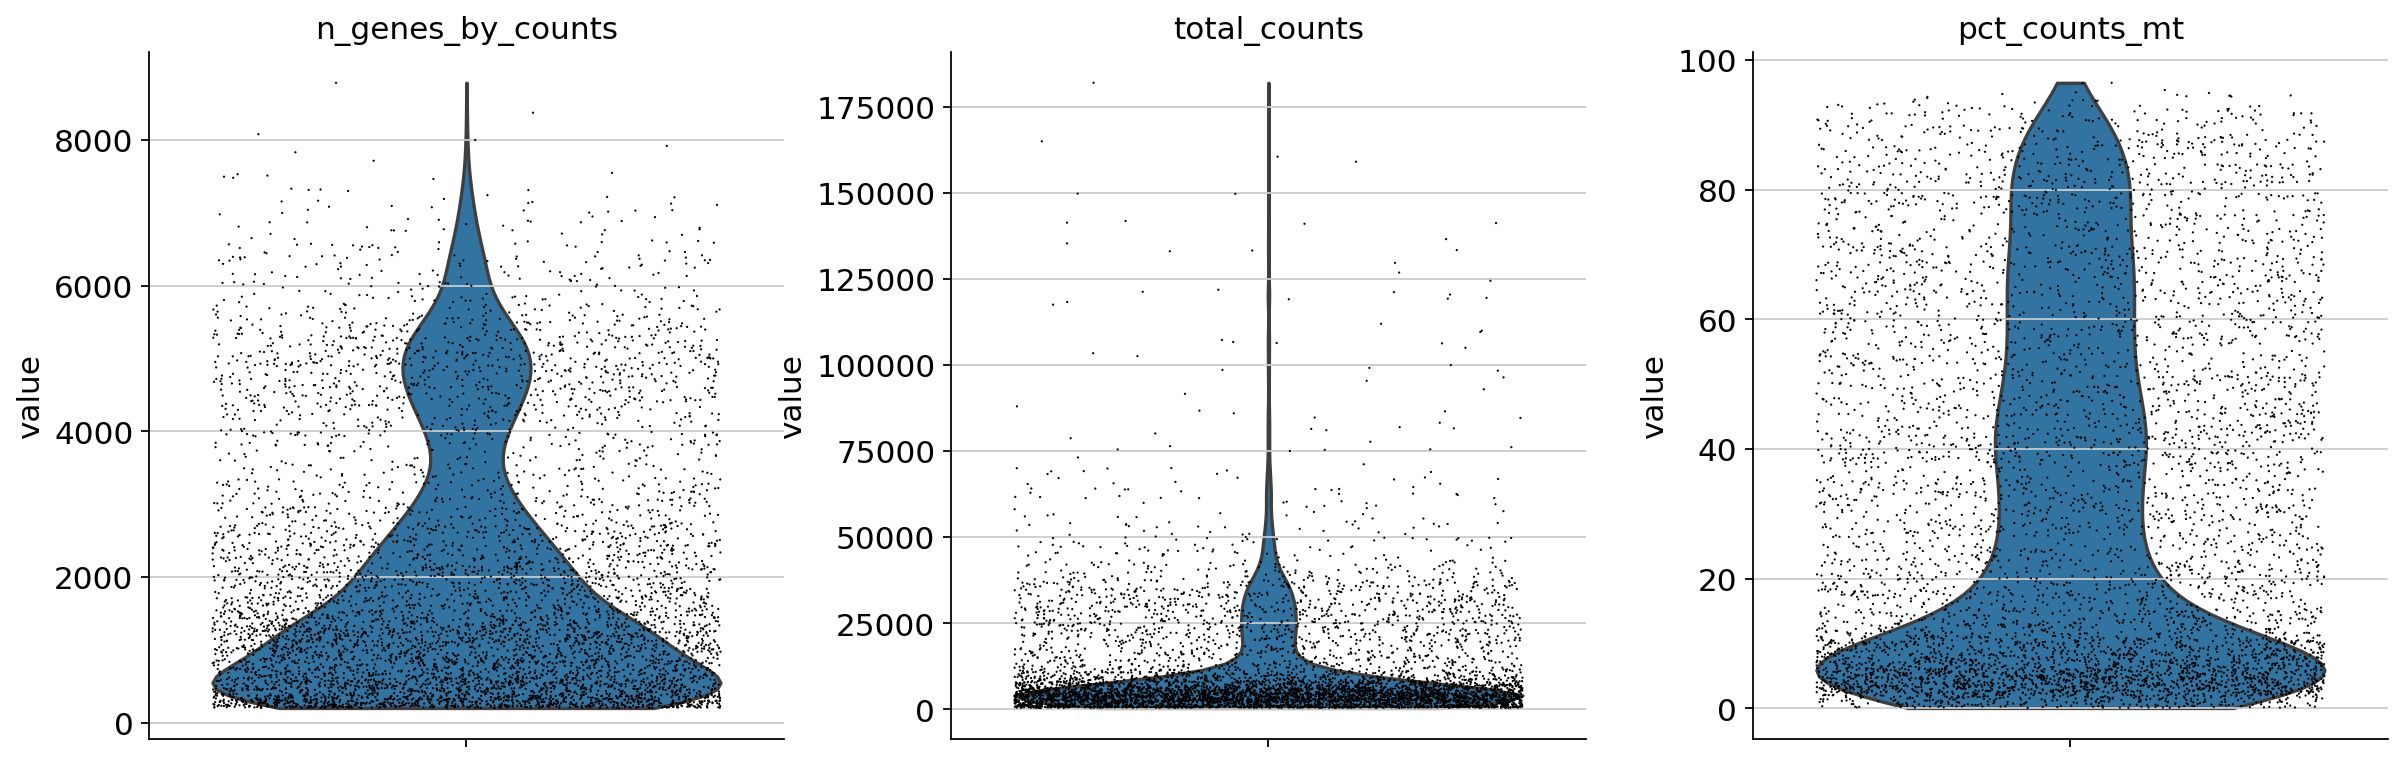

In [8]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

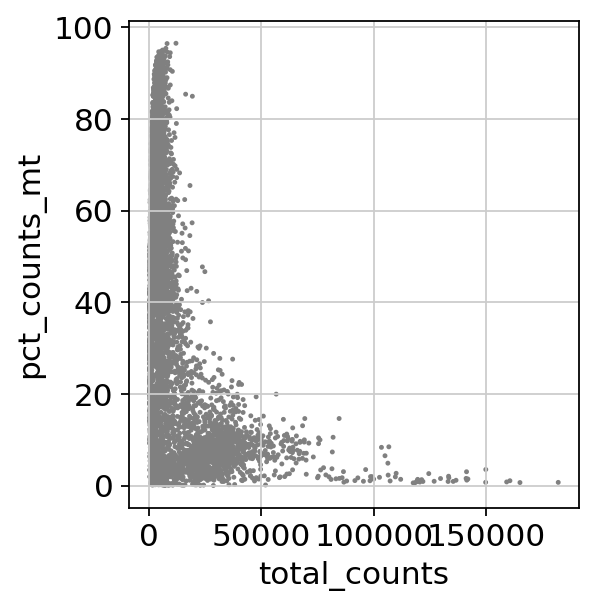

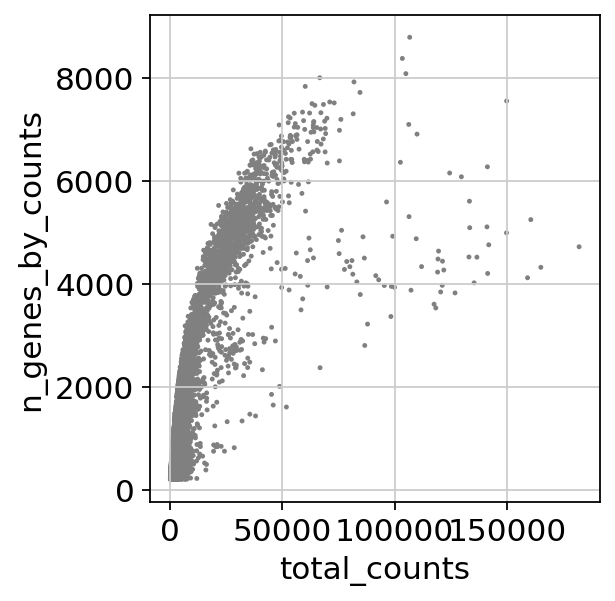

In [9]:
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

In [10]:
#filter cells
adata = adata[adata.obs.n_genes_by_counts > 1000, :]
adata = adata[adata.obs.pct_counts_mt < 15, :]

In [11]:
#remove mt and ribo genes
rbmt_gene_list = pd.read_csv ("genelist.mm.txt", sep = '\t',header=None)
rbmt_genes = rbmt_gene_list[1][rbmt_gene_list[0].isin(["RB","chrM"])]

In [12]:
excluded_genes = np.logical_not(adata.var["gene_ids"].isin(rbmt_genes))
adata_rbmtRM = adata[:,excluded_genes].copy()

In [13]:
sc.external.pp.scrublet(adata_rbmtRM,sim_doublet_ratio=20)
adata.obs['predicted_doublet'] = adata_rbmtRM.obs['predicted_doublet'].astype(int)
adata.obs['doublet_score'] = adata_rbmtRM.obs['doublet_score']

Running Scrublet
filtered out 714 genes that are detected in less than 3 cells
normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
normalizing counts per cell
    finished (0:00:00)
normalizing counts per cell


/home/chut/miniconda3/envs/cellrank_R/lib/python3.7/site-packages/scanpy/preprocessing/_normalization.py:155: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


    finished (0:00:00)
Embedding transcriptomes using PCA...
Automatically set threshold at doublet score = 0.34
Detected doublet rate = 0.9%
Estimated detectable doublet fraction = 35.3%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 2.5%
    Scrublet finished (0:00:43)


Trying to set attribute `.obs` of view, copying.


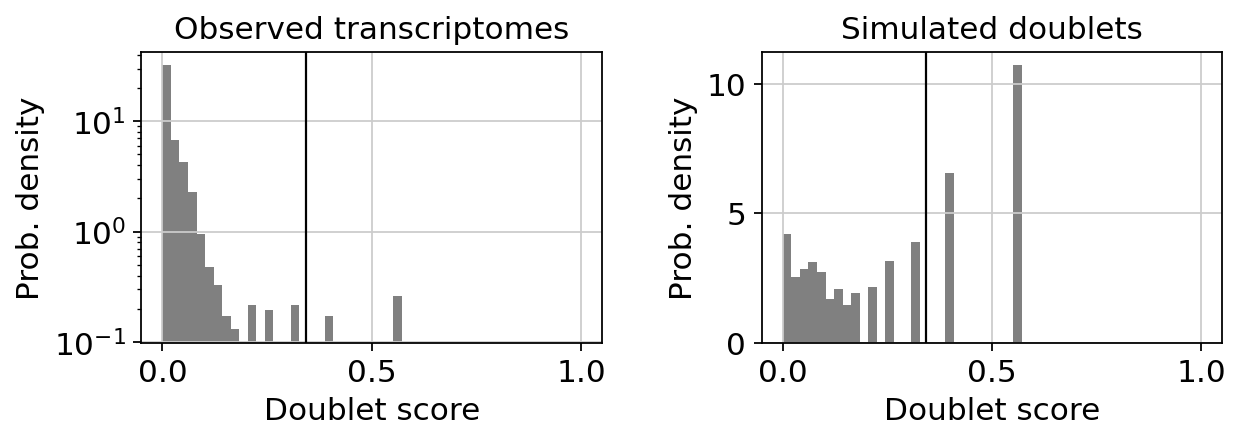

In [14]:
sc.external.pl.scrublet_score_distribution(adata_rbmtRM)

In [15]:
adata.layers["counts"] = adata.X.copy()
sc.pp.normalize_total(adata, target_sum = 1e4)
sc.pp.log1p(adata)
adata.raw = adata

normalizing counts per cell
    finished (0:00:00)


In [16]:
#remove mt and ribo genes
rbmt_gene_list = pd.read_csv ("genelist.mm.txt", sep = '\t',header=None)
rbmt_genes = rbmt_gene_list[1][rbmt_gene_list[0].isin(["RB","chrM"])]

In [17]:
excluded_genes = np.logical_not(adata.var["gene_ids"].isin(rbmt_genes))
adata = adata[:,excluded_genes].copy()

In [18]:
adata_dbRM = adata[adata.obs['predicted_doublet']==0,:]

In [19]:
adata_dbRM

View of AnnData object with n_obs × n_vars = 2239 × 18573
    obs: 'latent_cell_probability', 'latent_RT_efficiency', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'predicted_doublet', 'doublet_score'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'test_elbo', 'test_epoch', 'log1p'
    layers: 'counts'

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes


Trying to set attribute `.uns` of view, copying.


--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)
computing PCA
    on highly variable genes
    with n_comps=30
    finished (0:00:00)


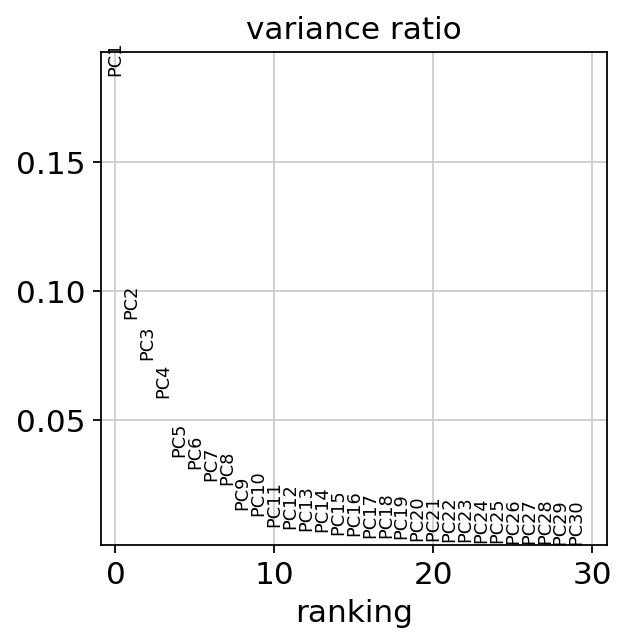

In [20]:
sc.pp.highly_variable_genes(
    adata_dbRM,
    n_top_genes = 5000,
    layer="counts",
    flavor="seurat_v3",
    span = 1
)

sc.tl.pca(adata_dbRM, svd_solver='arpack',n_comps=30)
sc.pl.pca_variance_ratio(adata_dbRM)

In [21]:
np.sum(adata_dbRM.uns["pca"]['variance_ratio'])

0.63641435

In [22]:
communities, graph, Q = phenograph.cluster(adata_dbRM.obsm['X_pca'],k=15,clustering_algo='leiden',seed=0)
print(np.unique(communities,return_counts=True))
adata_dbRM.obs['Phenograph_cluster_k15_dbRM'] = [str(x) for x in communities]
adata_dbRM.obs['Phenograph_cluster_k15_dbRM'] = adata_dbRM.obs['Phenograph_cluster_k15_dbRM'].astype("category")

Finding 15 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 0.7483208179473877 seconds
Jaccard graph constructed in 3.278975009918213 seconds
Running Leiden optimization
Leiden completed in 0.07076168060302734 seconds
Sorting communities by size, please wait ...
PhenoGraph completed in 7.5783491134643555 seconds
(array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
       16, 17, 18, 19, 20, 21, 22, 23, 24, 25]), array([ 10, 267, 234, 162, 159, 135, 128, 128, 127,  90,  89,  85,  83,
        80,  63,  54,  54,  40,  38,  37,  35,  33,  31,  26,  19,  16,
        16]))


In [23]:
sc.pp.neighbors(adata_dbRM, n_neighbors=30)
sc.tl.umap(adata_dbRM,min_dist=0.85)

computing neighbors
    using 'X_pca' with n_pcs = 30
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:02)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:06)


In [24]:
sig_gene_final = {'cell cycle':['Top2a','Mki67'],
                'enterocyte':['Alpi','Ephx2','Apoa1','Mttp','Apoa4','Fabp1','Lct','Prss32'],
                 'goblet':['Muc2','Ccl9','Tff3','Agr2'],
                 'paneth':['Lyz1','Defa17','Defa22','Defa24','Ang4'],
                  'secretory progenitor':['Atoh1', 'Spdef', 'Gfi1', 'Dll1'],
                  'TA/progenitor':['Stmn1','Tubb5','Prom1'],
                  'ISC':['Lgr5','Ascl2','Axin2','Olfm4','Sox9','Gkn3'],
                  'tuft':['Dclk1','Lrmp','Trpm5','Gfi1b','Cd24a'], #'Il25'
                  'EE':['Chga','Cpe','Chgb','Gfra3'], #'Tac1' #'Neurog3'
                  'endo':['Pecam1','Emcn','Cdh5','Flt4'],
                  'lymphatic':['Lyve1','Prox1','Ccl21a'],
                  'glial':['S100b','Gfap','Plp1'],
                  'myofibroblasts':['Acta2','Myh11','Vim'],
                  'stromal':['Col6a2','Col1a2','Vim','Pdgfra','Cd44','Dpt','Cd34'],
                  'pDC':['Irf8','Bst2','Runx2','Tcf4','Siglech'],
                  'macrophage':['Lyz1','Csf1r','Lyz2','Apoe','C1qa'],
                  'cDC/monocyte':['Flt3','Nr4a1','Batf3','Ccr2','Atox1','Ifi30'],
                  'plasma':['Igha','Igkc','Mzb1','Ccr10','Xbp1'],
                  'T cell':['Cd3g','Cd4','Cd8a','Cd3e'],
                  'resting B cell':['Ighd','Ebf1','Ighm'],
                  'cycling/GC B_cell':['Aicda','Hmgb2','Mbd4']
}

    using 'X_pca' with n_pcs = 30
Storing dendrogram info using `.uns['dendrogram_Phenograph_cluster_k15_dbRM']`
categories: -1, 0, 1, etc.
var_group_labels: cell cycle, enterocyte, goblet, etc.


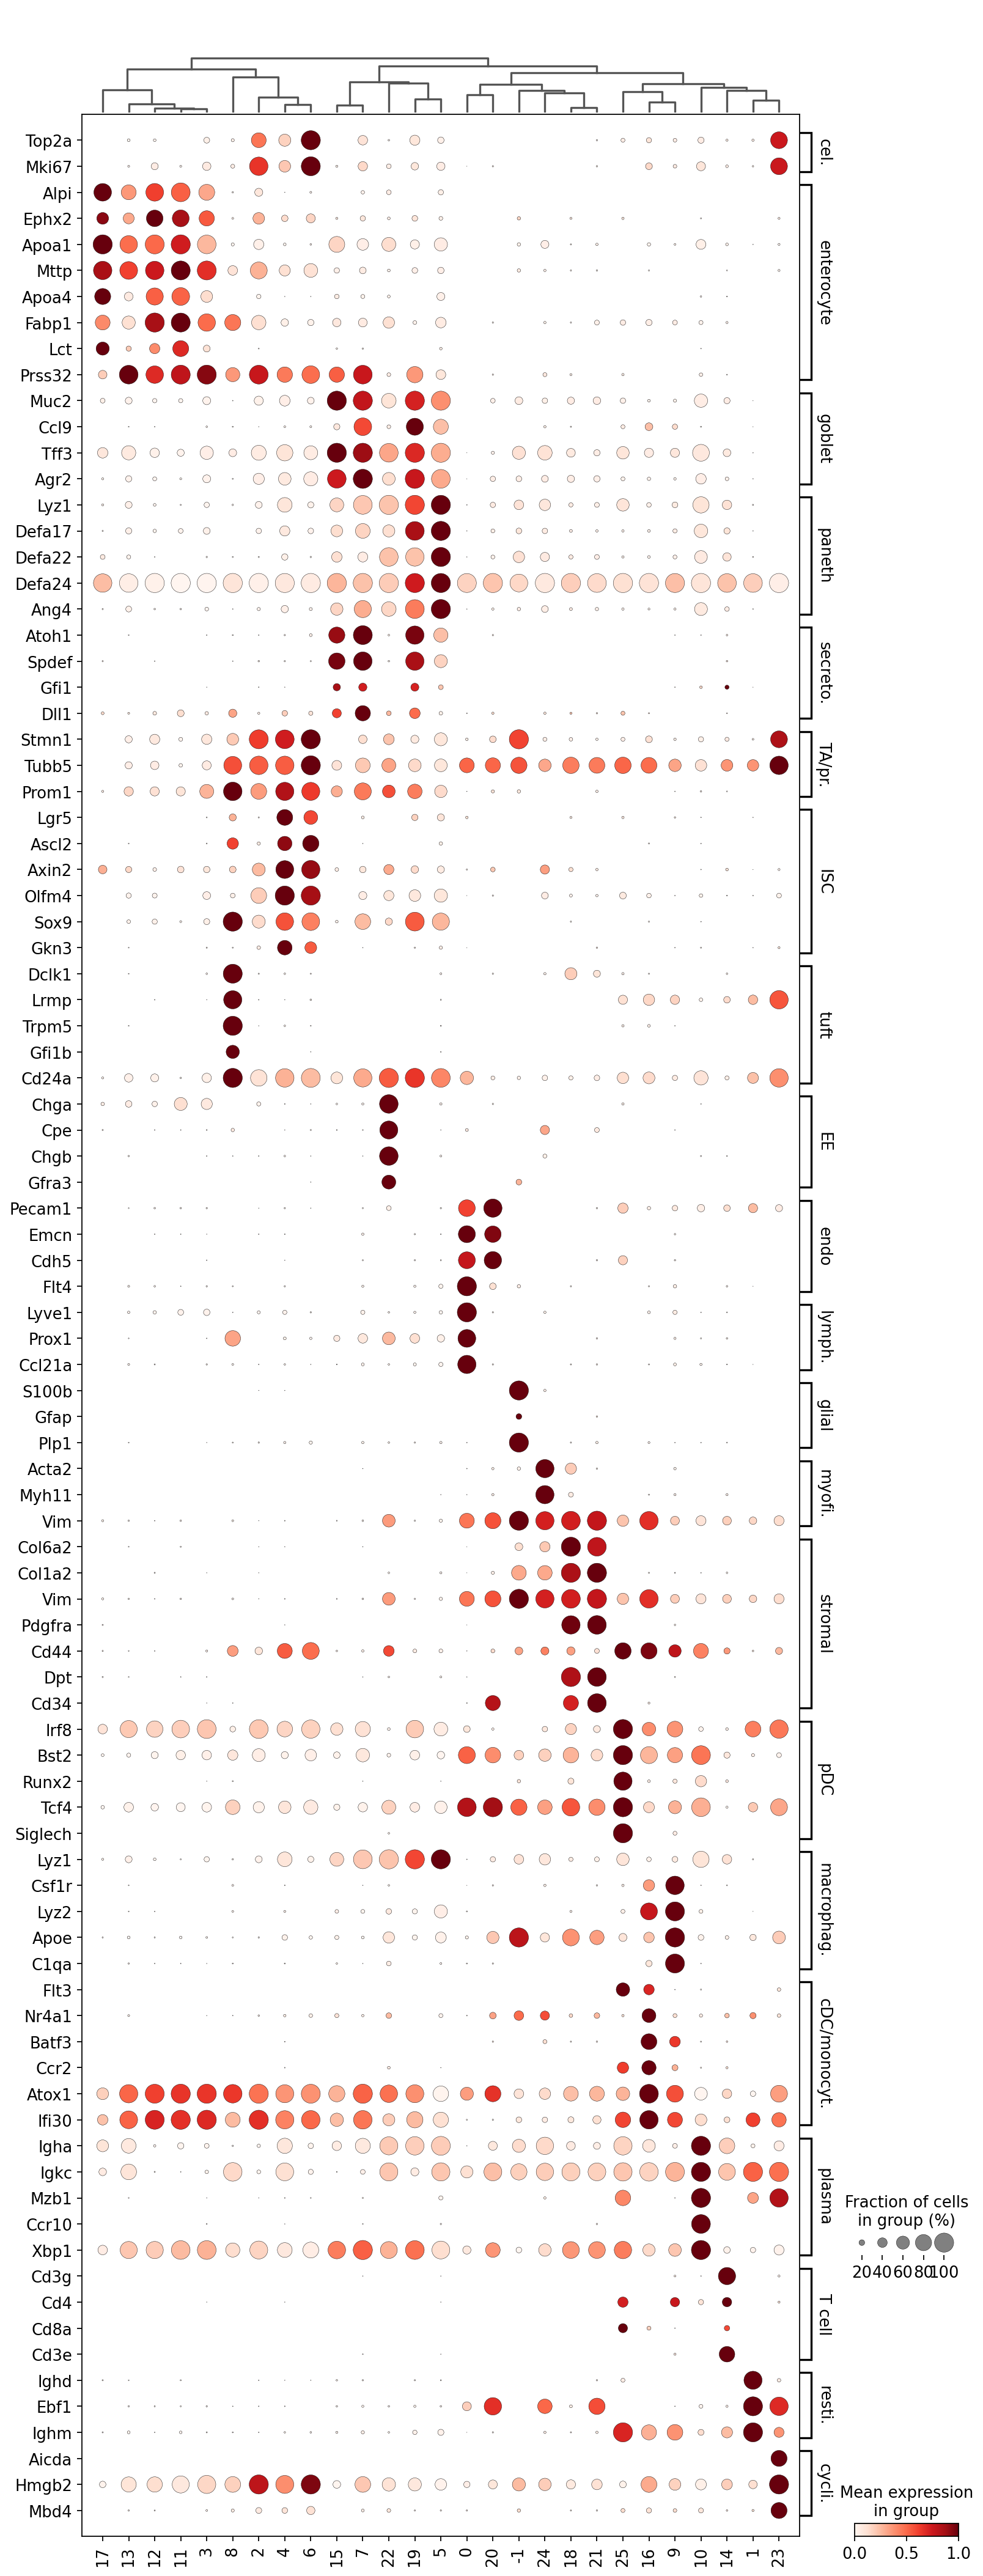

In [25]:
sc.tl.dendrogram(adata_dbRM,groupby='Phenograph_cluster_k15_dbRM')
sc.pl.dotplot(adata_dbRM,sig_gene_final,groupby='Phenograph_cluster_k15_dbRM',dendrogram=1,swap_axes=True,var_group_rotation=0, standard_scale='var')

In [26]:
coarse_annotation_dbRM = {
    '5':'Paneth',
    '22':'neurons/enteroendocrine',
    '14':'T cell',
    '16': 'cDC/monocyte','9':'macrophage',
    '10': 'plasma','23':'cycling/GC B cell','1':'rest B','25':'pDC',
    '19':'goblet','7':'goblet','15':'goblet',
    '0':'lymphatic',
    '20':'blood vasc.',
    '-1':'glial',
    '24':'str',
    '18':'str','21':'str',
    '8':'tuft',
    '4':'stem/TA','6':'stem/TA','2':'stem/TA',
    '11':'mature_enterocyte','12':'mature_enterocyte','13':'mature_enterocyte','17':'mature_enterocyte','3':'mature_enterocyte',
}

coarse_cluster_dbRM = [coarse_annotation_dbRM[x] for x in adata_dbRM.obs['Phenograph_cluster_k15_dbRM']]
adata_dbRM.obs['coarse_cluster_dbRM'] = coarse_cluster_dbRM

/home/chut/miniconda3/envs/cellrank_R/lib/python3.7/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'coarse_cluster_dbRM' as categorical


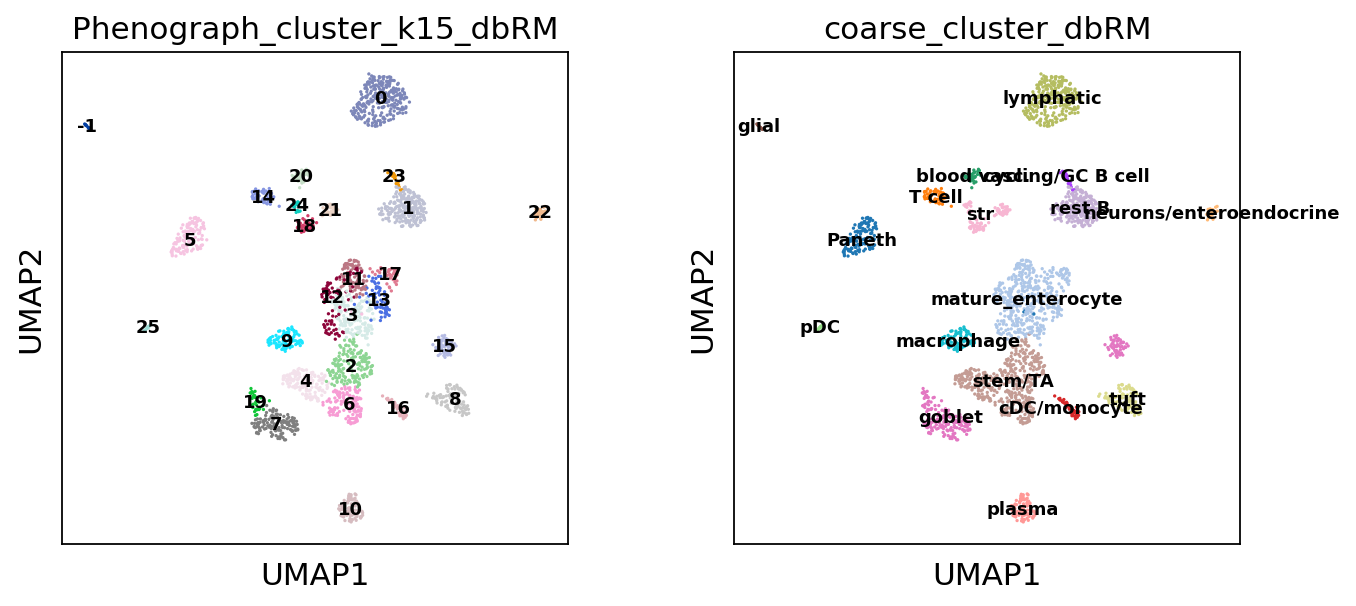

In [27]:
sc.pl.umap(adata_dbRM, color=['Phenograph_cluster_k15_dbRM','coarse_cluster_dbRM'],legend_loc='on data',size=20000/adata.obs.shape[0],legend_fontsize="xx-small")

In [28]:
#subcluster stem, TA, and enterocyte

In [29]:
adata_stem_ta_ent = adata_dbRM[adata_dbRM.obs['coarse_cluster_dbRM'].isin(np.array(['stem/TA','mature_enterocyte'])),:].copy()

In [30]:
adata_stem_ta_ent

AnnData object with n_obs × n_vars = 848 × 18573
    obs: 'latent_cell_probability', 'latent_RT_efficiency', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'predicted_doublet', 'doublet_score', 'Phenograph_cluster_k15_dbRM', 'coarse_cluster_dbRM'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'test_elbo', 'test_epoch', 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'dendrogram_Phenograph_cluster_k15_dbRM', 'Phenograph_cluster_k15_dbRM_colors', 'coarse_cluster_dbRM_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'distances', 'connectivities'

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)


/home/chut/miniconda3/envs/cellrank_R/lib/python3.7/site-packages/scanpy/plotting/_preprocessing.py:81: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  pl.xlim(0.95 * np.min(means), 1.05 * np.max(means))


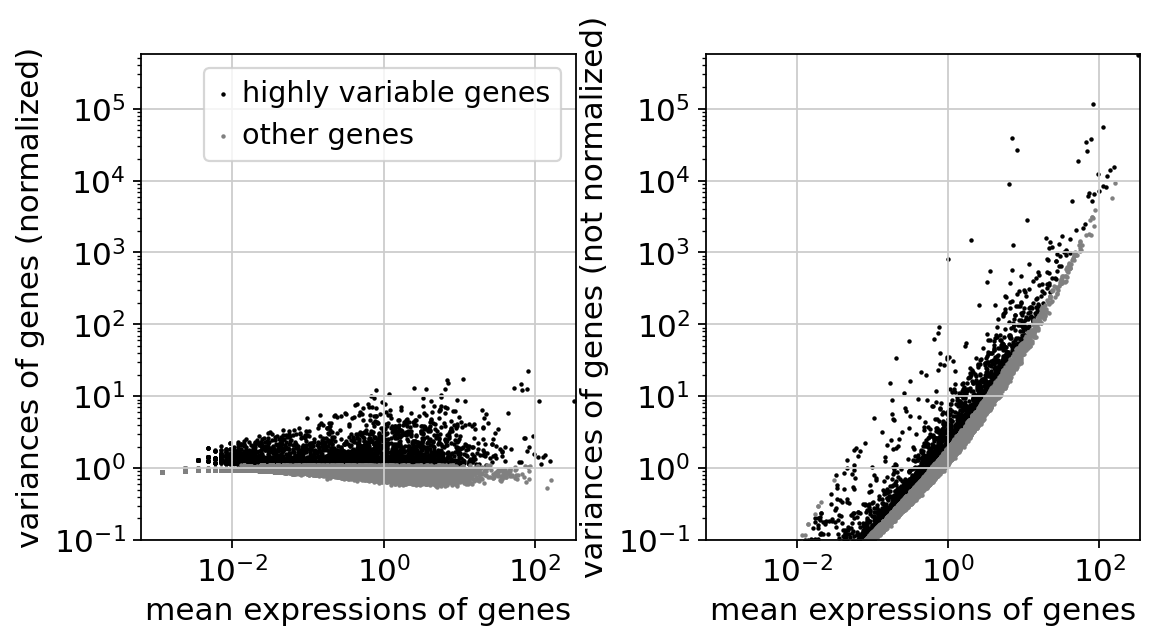

computing PCA
    on highly variable genes
    with n_comps=30
    finished (0:00:00)


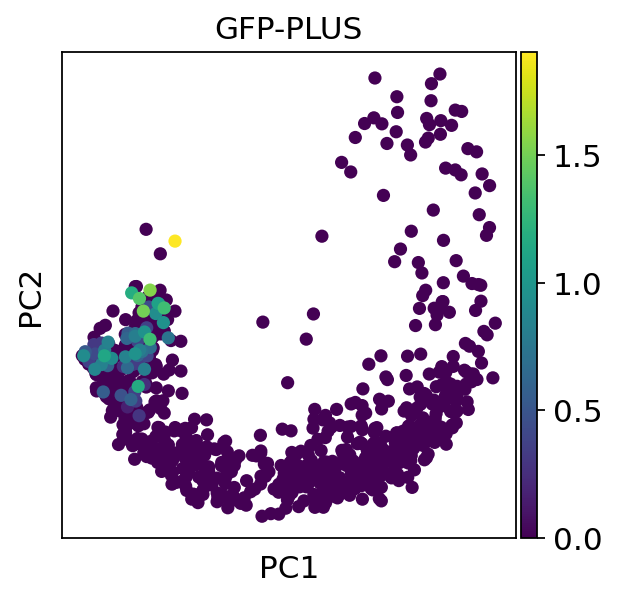

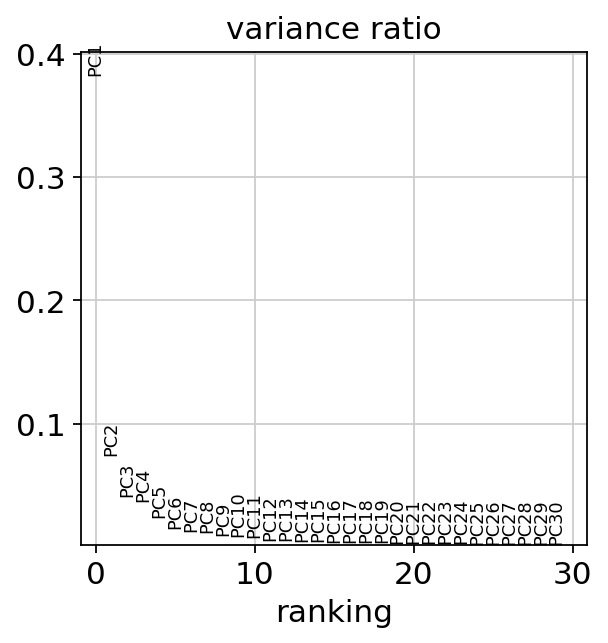

In [31]:
sc.pp.highly_variable_genes(
    adata_stem_ta_ent,
    n_top_genes = 3000,
    layer="counts",
    flavor="seurat_v3",
    span = 1
)
sc.pl.highly_variable_genes(adata_stem_ta_ent,log=True)
sc.tl.pca(adata_stem_ta_ent, svd_solver='arpack',n_comps=30)
sc.pl.pca(adata_stem_ta_ent, color='GFP-PLUS')
sc.pl.pca_variance_ratio(adata_stem_ta_ent,n_pcs=30)

In [32]:
communities, graph, Q = phenograph.cluster(adata_stem_ta_ent.obsm['X_pca'],k=30,clustering_algo='leiden',seed=0)
print(np.unique(communities,return_counts=True))
adata_stem_ta_ent.obs['Phenograph_cluster_stem_ta_ent_k30'] = [str(x) for x in communities]
adata_stem_ta_ent.obs['Phenograph_cluster_stem_ta_ent_k30'] = adata_stem_ta_ent.obs['Phenograph_cluster_stem_ta_ent_k30'].astype("category")

Finding 30 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 0.3400716781616211 seconds
Jaccard graph constructed in 3.674818515777588 seconds
Running Leiden optimization
Leiden completed in 0.015660762786865234 seconds
Sorting communities by size, please wait ...
PhenoGraph completed in 8.147156715393066 seconds
(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([157, 118,  97,  88,  84,  74,  69,  61,  58,  42]))


In [33]:
sig_gene_stem_ta_ent = {'cell cycle':['Top2a','Mki67'],
                'enterocyte':['Alpi','Ephx2','Apoa1','Mttp','Apoa4','Fabp1','Lct','Prss32'],
                  'TA/progenitor':['Stmn1','Tubb5','Prom1'],
                  'ISC':['Lgr5','Ascl2','Axin2','Olfm4','Sox9','Gkn3']
}

    using 'X_pca' with n_pcs = 30
Storing dendrogram info using `.uns['dendrogram_Phenograph_cluster_stem_ta_ent_k30']`
categories: 0, 1, 2, etc.
var_group_labels: cell cycle, enterocyte, TA/progenitor, etc.


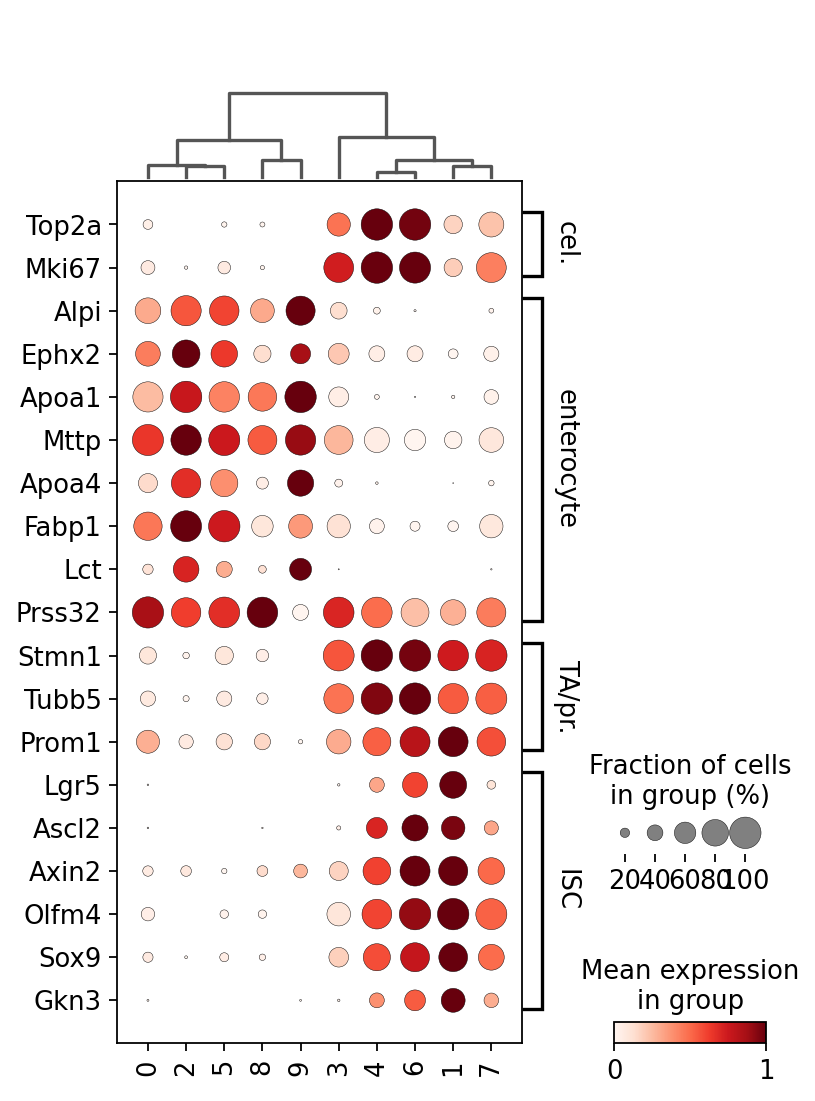

In [34]:
sc.tl.dendrogram(adata_stem_ta_ent,groupby='Phenograph_cluster_stem_ta_ent_k30')
sc.pl.dotplot(adata_stem_ta_ent,sig_gene_stem_ta_ent,groupby='Phenograph_cluster_stem_ta_ent_k30',dendrogram=1,swap_axes=True,var_group_rotation=0, standard_scale='var')

In [35]:
stem_ta_ent_annotation={
    '3':'stem/TA','4':'stem/TA','6':'stem/TA','1':'stem/TA','7':'stem/TA',
    '0':'mature_enterocyte', '2':'mature_enterocyte','5':'mature_enterocyte','8':'mature_enterocyte','9':'mature_enterocyte'
}

stem_ta_ent_cluster = [stem_ta_ent_annotation[x] for x in adata_stem_ta_ent.obs['Phenograph_cluster_stem_ta_ent_k30']]
adata_stem_ta_ent.obs['stem_ta_ent_cluster'] = stem_ta_ent_cluster


In [36]:
#subcluster enterocyte and annotate using the landmark genes
adata_ent = adata_stem_ta_ent[adata_stem_ta_ent.obs['stem_ta_ent_cluster']=='mature_enterocyte',:].copy()
adata_ent

AnnData object with n_obs × n_vars = 428 × 18573
    obs: 'latent_cell_probability', 'latent_RT_efficiency', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'predicted_doublet', 'doublet_score', 'Phenograph_cluster_k15_dbRM', 'coarse_cluster_dbRM', 'Phenograph_cluster_stem_ta_ent_k30', 'stem_ta_ent_cluster'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'test_elbo', 'test_epoch', 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'dendrogram_Phenograph_cluster_k15_dbRM', 'Phenograph_cluster_k15_dbRM_colors', 'coarse_cluster_dbRM_colors', 'dendrogram_Phenograph_cluster_stem_ta_ent_k30'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'distances', 'connectivities'

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)


/home/chut/miniconda3/envs/cellrank_R/lib/python3.7/site-packages/scanpy/plotting/_preprocessing.py:81: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  pl.xlim(0.95 * np.min(means), 1.05 * np.max(means))


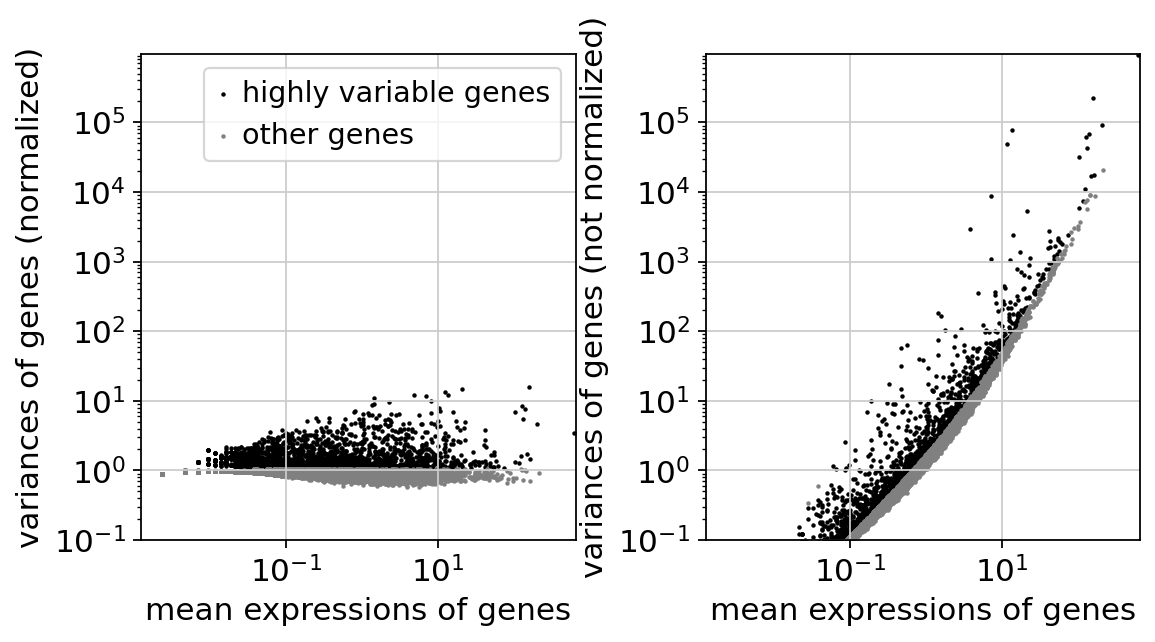

computing PCA
    on highly variable genes
    with n_comps=30
    finished (0:00:00)


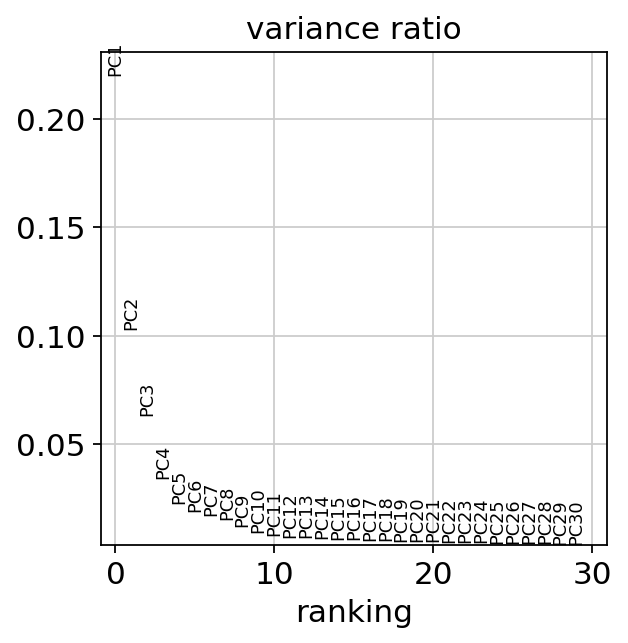

In [37]:
sc.pp.highly_variable_genes(
    adata_ent,
    n_top_genes = 3000,
    layer="counts",
    flavor="seurat_v3",
    span = 1
)
sc.pl.highly_variable_genes(adata_ent,log=True)
sc.tl.pca(adata_ent, svd_solver='arpack',n_comps=30)
sc.pl.pca_variance_ratio(adata_ent,n_pcs=30)

In [38]:
communities, graph, Q = phenograph.cluster(adata_ent.obsm['X_pca'],k=30,clustering_algo='leiden',seed=0)
print(np.unique(communities,return_counts=True))
adata_ent.obs['Phenograph_cluster_ent_k30'] = [str(x) for x in communities]
adata_ent.obs['Phenograph_cluster_ent_k30'] = adata_ent.obs['Phenograph_cluster_ent_k30'].astype("category")

Finding 30 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 0.4911055564880371 seconds
Jaccard graph constructed in 4.294345855712891 seconds
Running Leiden optimization
Leiden completed in 0.017438650131225586 seconds
Sorting communities by size, please wait ...
PhenoGraph completed in 8.803773164749146 seconds
(array([0, 1, 2, 3, 4, 5, 6, 7, 8]), array([90, 56, 56, 50, 40, 39, 34, 32, 31]))


In [39]:
marker_df = pd.read_csv ("/data/peer/tinyi/RU_data/scRNA/python_processing_script/bottom_top_landmark_genes.csv", sep = ',',header=0)
landmark_genes={}
all_cell_types = marker_df.columns
for cell_type_i in all_cell_types:
    marker_i = marker_df.loc[:,cell_type_i].to_numpy().astype(str)
    marker_i = np.intersect1d(marker_i, adata_dbRM.var_names.to_numpy())
    landmark_genes[cell_type_i] = marker_i

In [40]:
adata_ent.layers['z_score'] = sc.pp.scale(adata_ent,copy=True).X.copy()
for zone_id in landmark_genes.keys():
    zone_genes_i = landmark_genes[zone_id]
    z_score_sum = np.sum(adata_ent[:,zone_genes_i].layers['z_score'],axis=1)
    adata_ent.obs[zone_id] = z_score_sum

... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


/home/chut/miniconda3/envs/cellrank_R/lib/python3.7/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'stem_ta_ent_cluster' as categorical


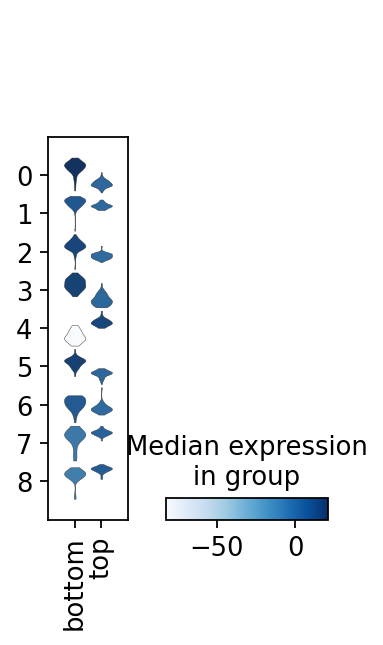

In [41]:
sc.pl.stacked_violin(adata_ent, var_names=list(landmark_genes.keys()), groupby='Phenograph_cluster_ent_k30')

In [42]:
ent_annotation={
    '4':'top zone enterocyte',
    '7':'mid zone enterocyte','8':'mid zone enterocyte', 
    '0':'bottom zone enterocyte','1':'bottom zone enterocyte','2':'bottom zone enterocyte','3':'bottom zone enterocyte','5':'bottom zone enterocyte','6':'bottom zone enterocyte'
}

ent_cluster = [ent_annotation[x] for x in adata_ent.obs['Phenograph_cluster_ent_k30']]
adata_ent.obs['ent_cluster'] = ent_cluster

In [43]:
#subcluster stem and TA
adata_stem = adata_stem_ta_ent[adata_stem_ta_ent.obs['stem_ta_ent_cluster']=='stem/TA',:].copy()
adata_stem

AnnData object with n_obs × n_vars = 420 × 18573
    obs: 'latent_cell_probability', 'latent_RT_efficiency', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'predicted_doublet', 'doublet_score', 'Phenograph_cluster_k15_dbRM', 'coarse_cluster_dbRM', 'Phenograph_cluster_stem_ta_ent_k30', 'stem_ta_ent_cluster'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'test_elbo', 'test_epoch', 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'dendrogram_Phenograph_cluster_k15_dbRM', 'Phenograph_cluster_k15_dbRM_colors', 'coarse_cluster_dbRM_colors', 'dendrogram_Phenograph_cluster_stem_ta_ent_k30'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'distances', 'connectivities'

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)


/home/chut/miniconda3/envs/cellrank_R/lib/python3.7/site-packages/scanpy/plotting/_preprocessing.py:81: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  pl.xlim(0.95 * np.min(means), 1.05 * np.max(means))


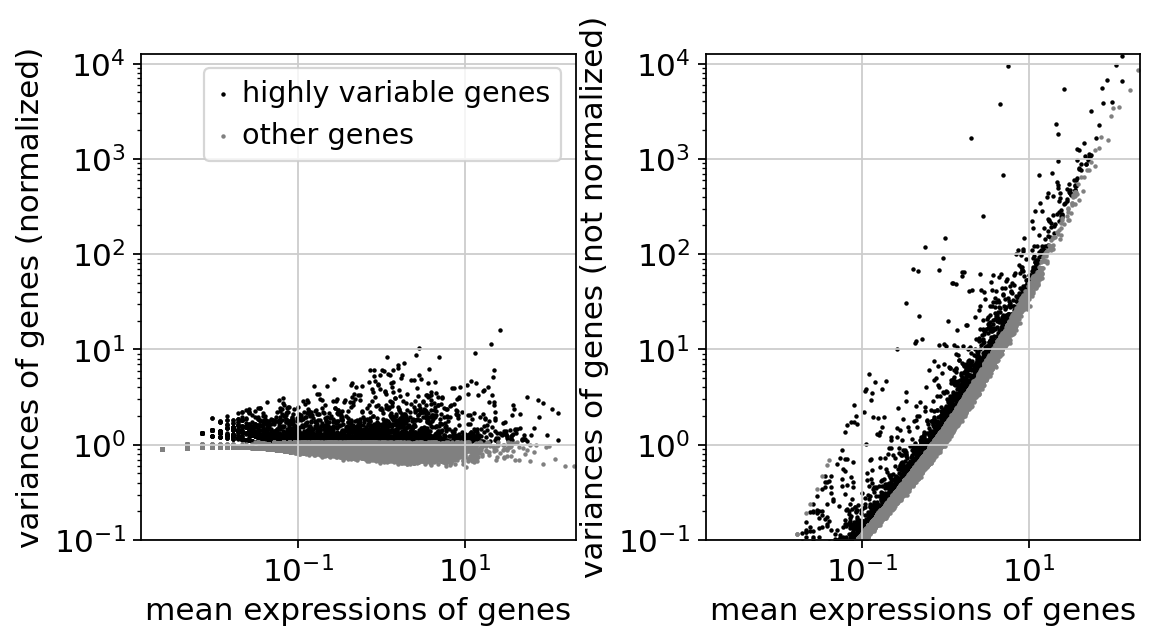

computing PCA
    on highly variable genes
    with n_comps=30
    finished (0:00:00)


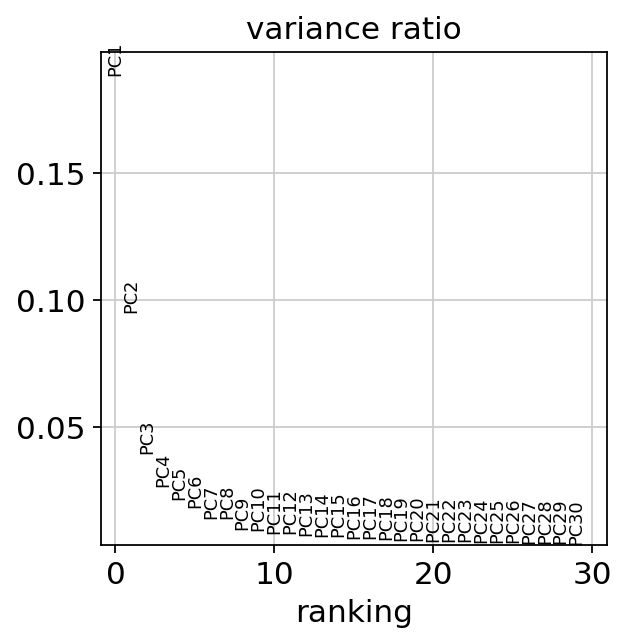

In [44]:
sc.pp.highly_variable_genes(
    adata_stem,
    n_top_genes = 3000,
    layer="counts",
    flavor="seurat_v3",
    span = 1
)
sc.pl.highly_variable_genes(adata_stem,log=True)
sc.tl.pca(adata_stem, svd_solver='arpack',n_comps=30)
sc.pl.pca_variance_ratio(adata_stem,n_pcs=30)

In [45]:
communities, graph, Q = phenograph.cluster(adata_stem.obsm['X_pca'],k=30,clustering_algo='leiden',seed=0)
print(np.unique(communities,return_counts=True))
adata_stem.obs['Phenograph_cluster_stem_k30'] = [str(x) for x in communities]
adata_stem.obs['Phenograph_cluster_stem_k30'] = adata_stem.obs['Phenograph_cluster_stem_k30'].astype("category")

Finding 30 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 1.2948753833770752 seconds
Jaccard graph constructed in 4.297932863235474 seconds
Running Leiden optimization
Leiden completed in 0.012470006942749023 seconds
Sorting communities by size, please wait ...
PhenoGraph completed in 11.1040780544281 seconds
(array([0, 1, 2, 3, 4, 5, 6]), array([86, 81, 68, 66, 40, 40, 39]))


In [46]:
sig_gene_stem_ta = {'cell cycle':['Top2a','Mki67'],
                  'TA/progenitor':['Stmn1','Tubb5','Prom1'],
                  'ISC':['Lgr5','Ascl2','Axin2','Olfm4','Sox9','Gkn3']
}

    using 'X_pca' with n_pcs = 30
Storing dendrogram info using `.uns['dendrogram_Phenograph_cluster_stem_k30']`


/home/chut/miniconda3/envs/cellrank_R/lib/python3.7/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'stem_ta_ent_cluster' as categorical


categories: 0, 1, 2, etc.
var_group_labels: cell cycle, TA/progenitor, ISC


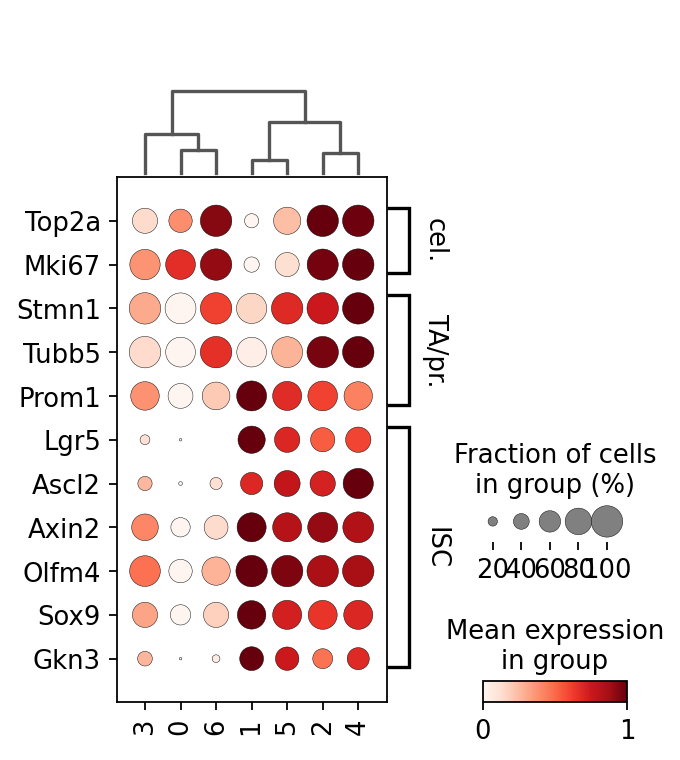

In [47]:
sc.tl.dendrogram(adata_stem,groupby='Phenograph_cluster_stem_k30')
sc.pl.dotplot(adata_stem,sig_gene_stem_ta,groupby='Phenograph_cluster_stem_k30',dendrogram=1,swap_axes=True,var_group_rotation=0, standard_scale='var')

In [48]:
stem_annotation={
    '1':'Lgr5+ stem','5':'Lgr5+ stem',
    '2':'Lgr5+ progenitor','4':'Lgr5+ progenitor',
    '3':'TA','0':'TA','6':'TA'
}

stem_cluster = [stem_annotation[x] for x in adata_stem.obs['Phenograph_cluster_stem_k30']]
adata_stem.obs['stem_cluster'] = stem_cluster

In [49]:
#subcluster goblets:
adata_gob = adata_dbRM[adata_dbRM.obs['coarse_cluster_dbRM']=="goblet",:].copy()
adata_gob

AnnData object with n_obs × n_vars = 216 × 18573
    obs: 'latent_cell_probability', 'latent_RT_efficiency', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'predicted_doublet', 'doublet_score', 'Phenograph_cluster_k15_dbRM', 'coarse_cluster_dbRM'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'test_elbo', 'test_epoch', 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'dendrogram_Phenograph_cluster_k15_dbRM', 'Phenograph_cluster_k15_dbRM_colors', 'coarse_cluster_dbRM_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'distances', 'connectivities'

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)


/home/chut/miniconda3/envs/cellrank_R/lib/python3.7/site-packages/scanpy/plotting/_preprocessing.py:81: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  pl.xlim(0.95 * np.min(means), 1.05 * np.max(means))


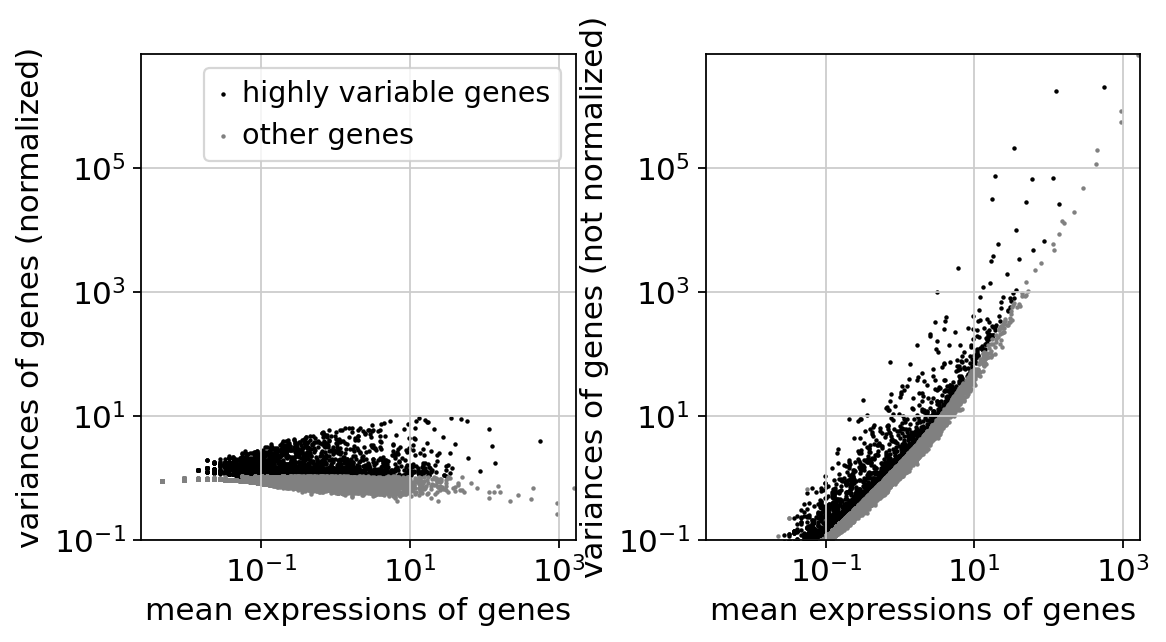

computing PCA
    on highly variable genes
    with n_comps=30
    finished (0:00:00)


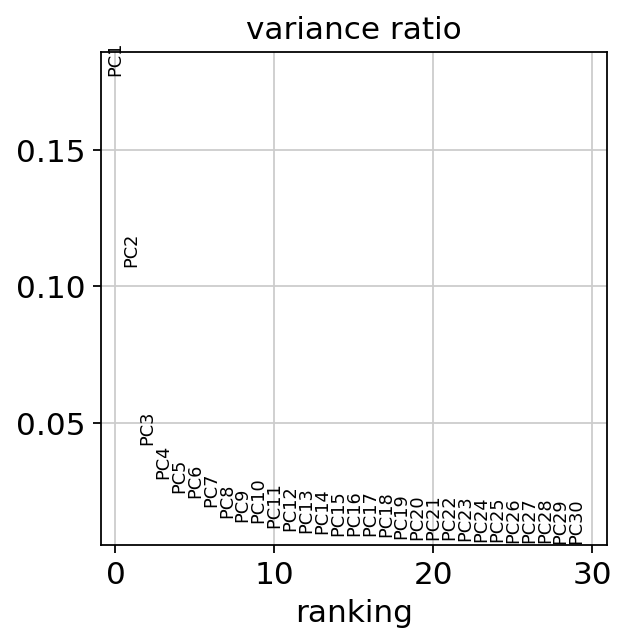

In [50]:
sc.pp.highly_variable_genes(
    adata_gob,
    n_top_genes = 3000,
    layer="counts",
    flavor="seurat_v3",
    span = 1
)
sc.pl.highly_variable_genes(adata_gob,log=True)
sc.tl.pca(adata_gob, svd_solver='arpack',n_comps=30)
sc.pl.pca_variance_ratio(adata_gob,n_pcs=30)

In [51]:
communities, graph, Q = phenograph.cluster(adata_gob.obsm['X_pca'],k=30,clustering_algo='leiden',seed=0)
print(np.unique(communities,return_counts=True))
adata_gob.obs['Phenograph_cluster_gob_k30'] = [str(x) for x in communities]
adata_gob.obs['Phenograph_cluster_gob_k30'] = adata_gob.obs['Phenograph_cluster_gob_k30'].astype("category")

Finding 30 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 0.12235045433044434 seconds
Jaccard graph constructed in 3.7108211517333984 seconds
Running Leiden optimization
Leiden completed in 0.005869865417480469 seconds
Sorting communities by size, please wait ...
PhenoGraph completed in 7.808244705200195 seconds
(array([0, 1, 2, 3, 4]), array([63, 56, 46, 35, 16]))


    using 'X_pca' with n_pcs = 30
Storing dendrogram info using `.uns['dendrogram_Phenograph_cluster_gob_k30']`
categories: 0, 1, 2, etc.
var_group_labels: cell cycle, goblet, paneth, etc.


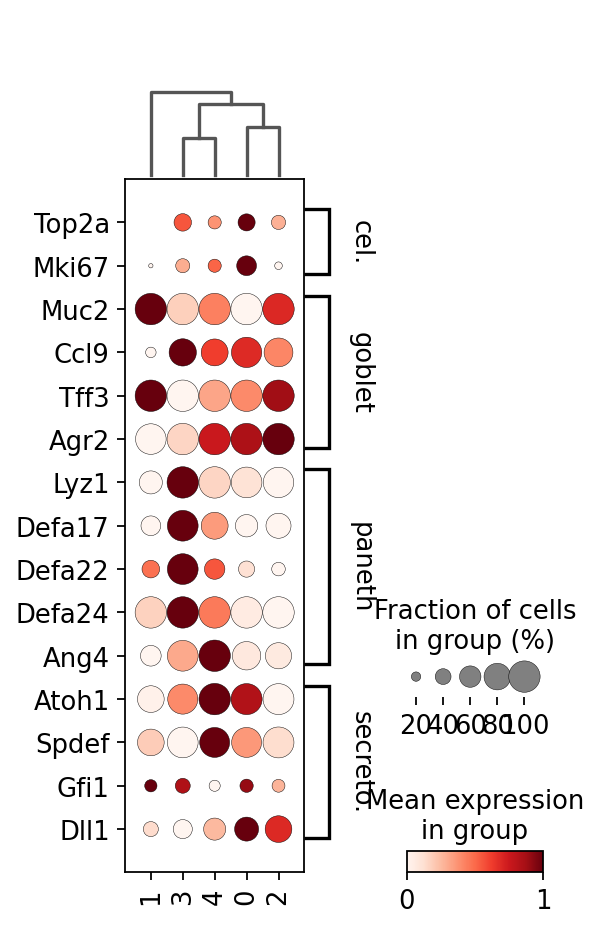

In [52]:
sig_gene_gob = {'cell cycle':['Top2a','Mki67'],
                 'goblet':['Muc2','Ccl9','Tff3','Agr2'],
                'paneth':['Lyz1','Defa17','Defa22','Defa24','Ang4'],
                  'secretory progenitor':['Atoh1', 'Spdef', 'Gfi1', 'Dll1']
}
sc.tl.dendrogram(adata_gob,groupby='Phenograph_cluster_gob_k30')
sc.pl.dotplot(adata_gob,sig_gene_gob,groupby='Phenograph_cluster_gob_k30',dendrogram=1,swap_axes=True,var_group_rotation=0, standard_scale='var')

In [53]:
gob_annotation={
    '3':'secretory progenitor', # express both paneth and goblet genes
    '0':'goblet cycling','4':'goblet cycling',#high Mki67
    '2':'goblet 1','1':'goblet 2'
}

gob_cluster = [gob_annotation[x] for x in adata_gob.obs['Phenograph_cluster_gob_k30']]
adata_gob.obs['gob_cluster'] = gob_cluster

In [54]:
#reculster str cell
adata_str = adata_dbRM[adata_dbRM.obs['coarse_cluster_dbRM']=='str',:].copy()
adata_str

AnnData object with n_obs × n_vars = 84 × 18573
    obs: 'latent_cell_probability', 'latent_RT_efficiency', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'predicted_doublet', 'doublet_score', 'Phenograph_cluster_k15_dbRM', 'coarse_cluster_dbRM'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'test_elbo', 'test_epoch', 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'dendrogram_Phenograph_cluster_k15_dbRM', 'Phenograph_cluster_k15_dbRM_colors', 'coarse_cluster_dbRM_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'distances', 'connectivities'

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)


/home/chut/miniconda3/envs/cellrank_R/lib/python3.7/site-packages/scanpy/plotting/_preprocessing.py:81: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  pl.xlim(0.95 * np.min(means), 1.05 * np.max(means))


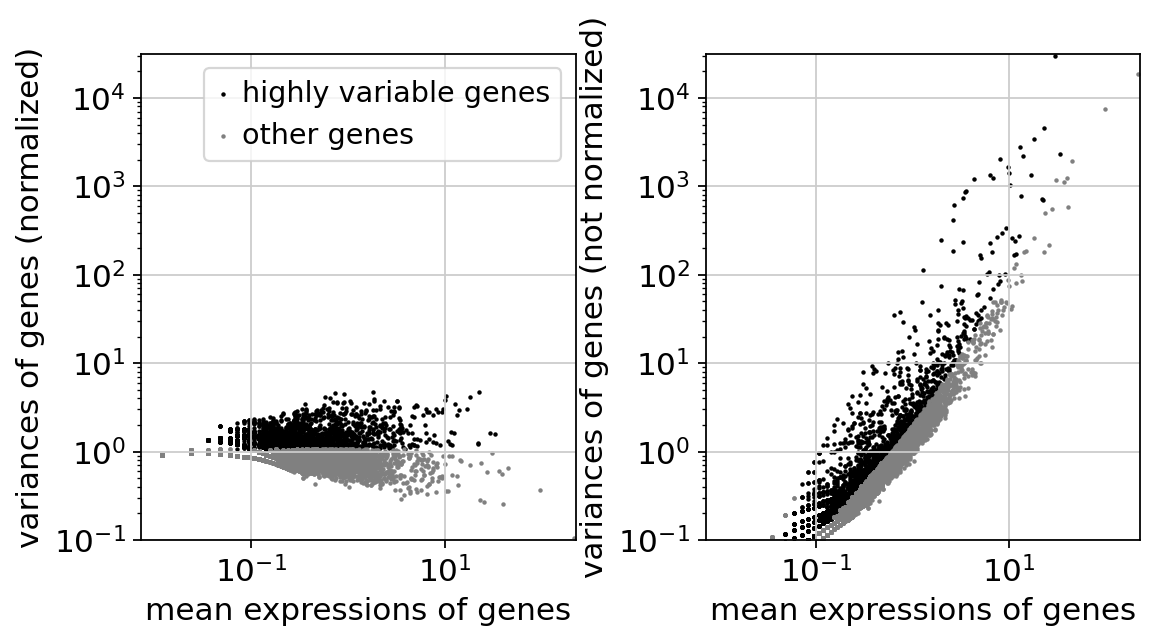

computing PCA
    on highly variable genes
    with n_comps=30
    finished (0:00:00)


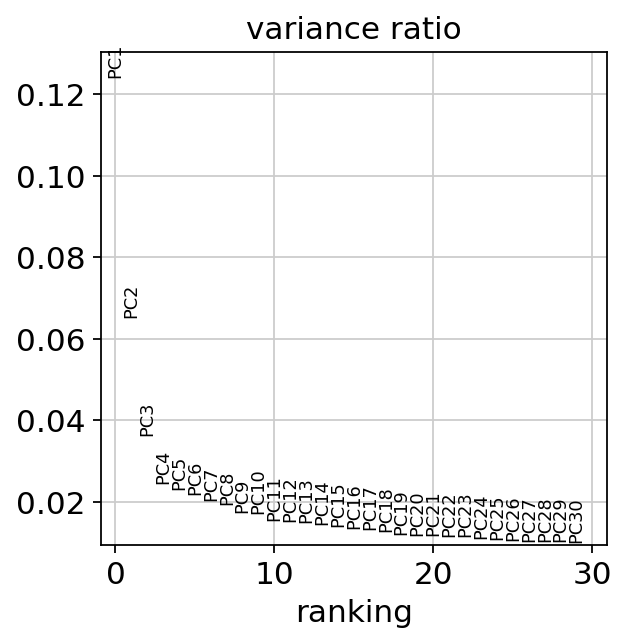

In [55]:
sc.pp.highly_variable_genes(
    adata_str,
    n_top_genes = 3000,
    layer="counts",
    flavor="seurat_v3",
    span = 1
)
sc.pl.highly_variable_genes(adata_str,log=True)
sc.tl.pca(adata_str, svd_solver='arpack',n_comps=30)
sc.pl.pca_variance_ratio(adata_str,n_pcs=30)

In [56]:
communities, graph, Q = phenograph.cluster(adata_str.obsm['X_pca'],k=30,clustering_algo='leiden',seed=0)
print(np.unique(communities,return_counts=True))
adata_str.obs['Phenograph_cluster_str_k30'] = [str(x) for x in communities]
adata_str.obs['Phenograph_cluster_str_k30'] = adata_str.obs['Phenograph_cluster_str_k30'].astype("category")

Finding 30 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 0.11105203628540039 seconds
Jaccard graph constructed in 3.4800844192504883 seconds
Running Leiden optimization
Leiden completed in 0.0018885135650634766 seconds
Sorting communities by size, please wait ...
PhenoGraph completed in 7.762781381607056 seconds
(array([0, 1, 2]), array([38, 32, 14]))


    using 'X_pca' with n_pcs = 30
Storing dendrogram info using `.uns['dendrogram_Phenograph_cluster_str_k30']`
categories: 0, 1, 2
var_group_labels: stromal, telocytes, trophocytes, etc.


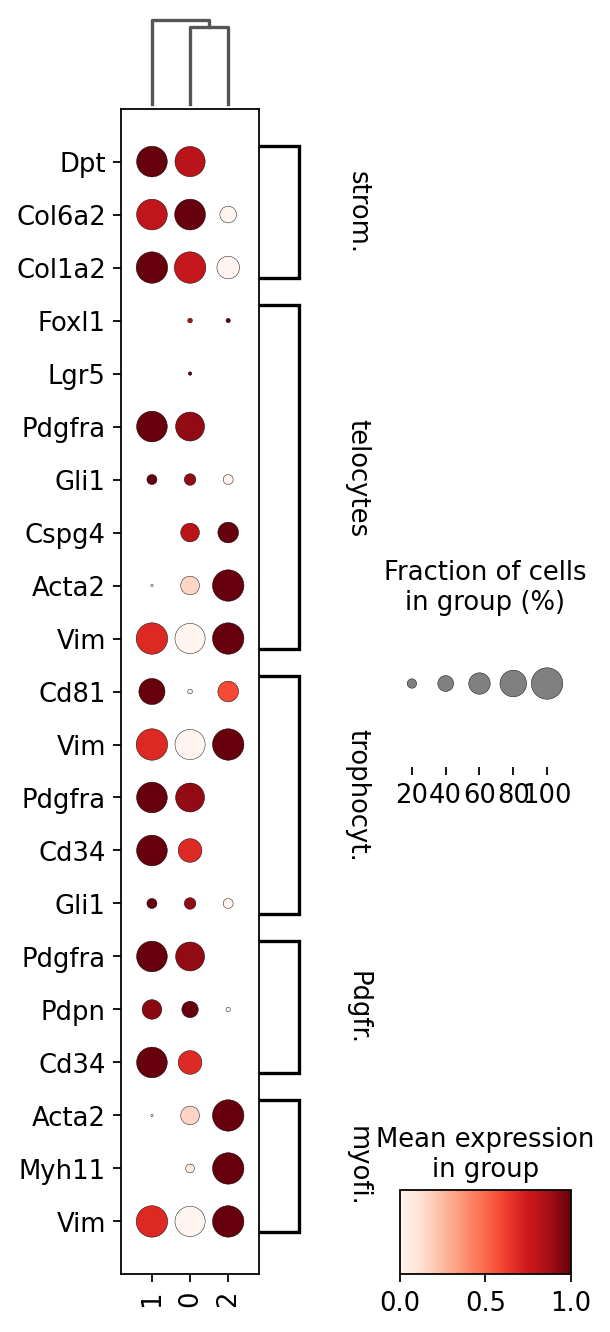

In [57]:
str_gene_list={'stromal':['Dpt','Col6a2','Col1a2'],
                'telocytes':['Foxl1','Lgr5','Pdgfra','Gli1','Cspg4','Acta2','Vim'],
                'trophocytes':['Cd81','Vim','Pdgfra','Cd34','Gli1'],
                'Pdgfra low pericryptal fibroblasts':['Pdgfra','Pdpn','Cd34'],
               'myofibroblasts':['Acta2','Myh11','Vim']
              }
sc.tl.dendrogram(adata_str,groupby='Phenograph_cluster_str_k30')
sc.pl.dotplot(adata_str,str_gene_list,groupby='Phenograph_cluster_str_k30',dendrogram=1,swap_axes=True,var_group_rotation=0, standard_scale='var',figsize=(3.6,10))

In [58]:
str_annotation={
    '2':'myofibroblast',
    '0':'stromal 1/2','1':'stromal 3'
}
str_cluster = [str_annotation[x] for x in adata_str.obs['Phenograph_cluster_str_k30']]
adata_str.obs['str_cluster'] = str_cluster

In [59]:
adata_ent.obs.columns

Index(['latent_cell_probability', 'latent_RT_efficiency', 'n_genes',
       'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt',
       'predicted_doublet', 'doublet_score', 'Phenograph_cluster_k15_dbRM',
       'coarse_cluster_dbRM', 'Phenograph_cluster_stem_ta_ent_k30',
       'stem_ta_ent_cluster', 'Phenograph_cluster_ent_k30', 'bottom', 'top',
       'ent_cluster'],
      dtype='object')

In [60]:
#transfer labels from adata_ent,adata_stem, adata_gob, and adata_str to adata_dbRM  

adata_dbRM.obs['cell_state'] = adata_dbRM.obs['coarse_cluster_dbRM'].astype(str)    

for idx in adata_stem.obs.index:
    adata_dbRM.obs['cell_state'][idx] = adata_stem.obs['stem_cluster'][idx]
for idx in adata_ent.obs.index:
    adata_dbRM.obs['cell_state'][idx] = adata_ent.obs['ent_cluster'][idx]
for idx in adata_gob.obs.index:
    adata_dbRM.obs['cell_state'][idx] = adata_gob.obs['gob_cluster'][idx]
for idx in adata_str.obs.index:
    adata_dbRM.obs['cell_state'][idx] = adata_str.obs['str_cluster'][idx]   

/home/chut/miniconda3/envs/cellrank_R/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/chut/miniconda3/envs/cellrank_R/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/chut/miniconda3/envs/cellrank_R/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys

/home/chut/miniconda3/envs/cellrank_R/lib/python3.7/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'cell_state' as categorical


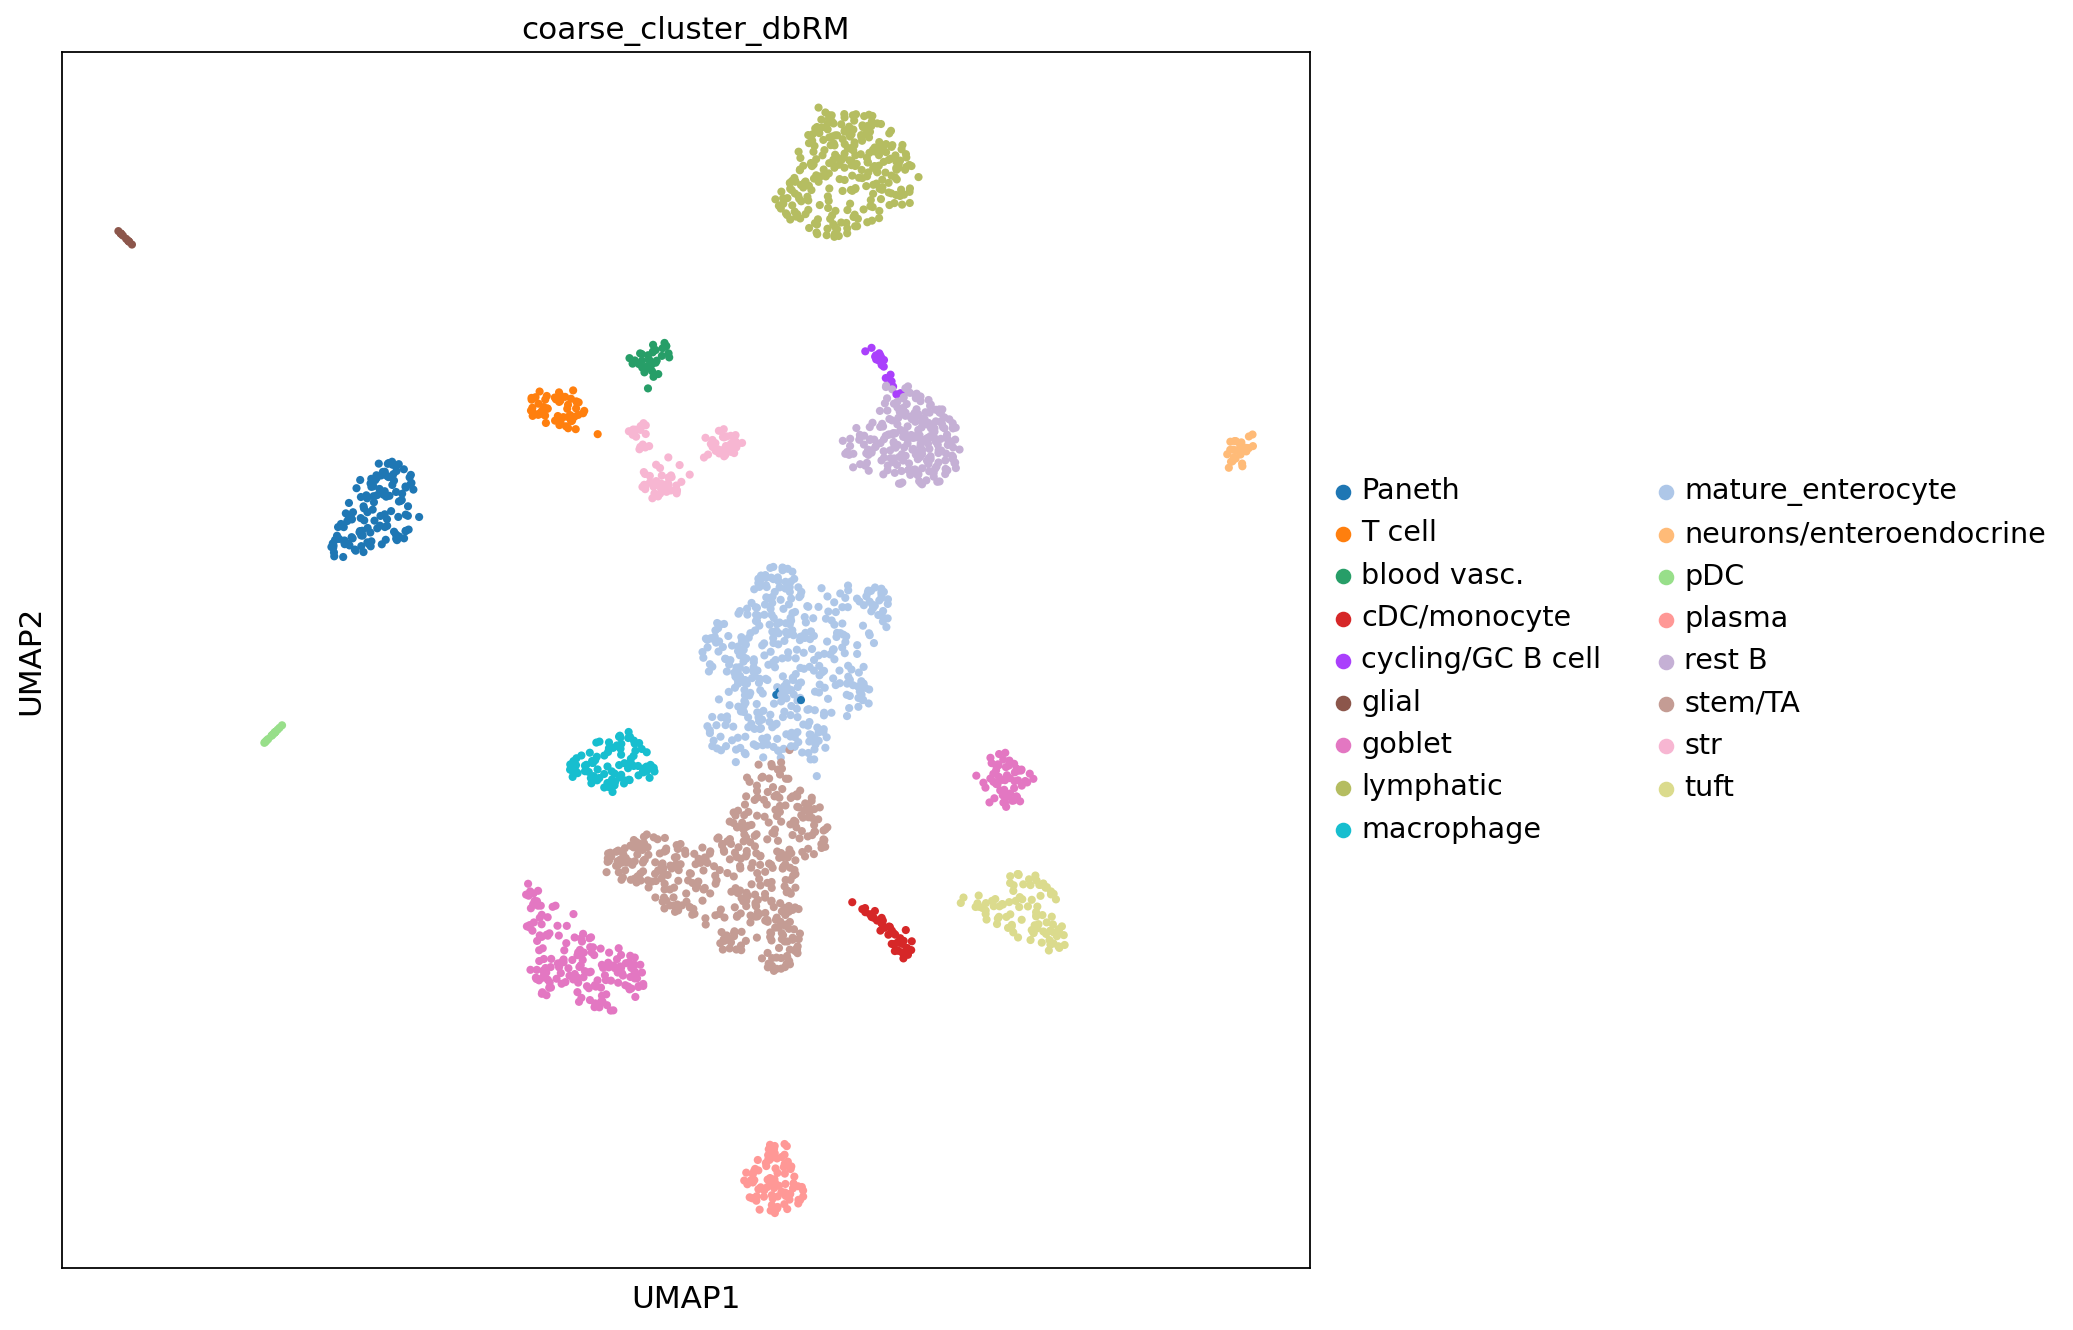

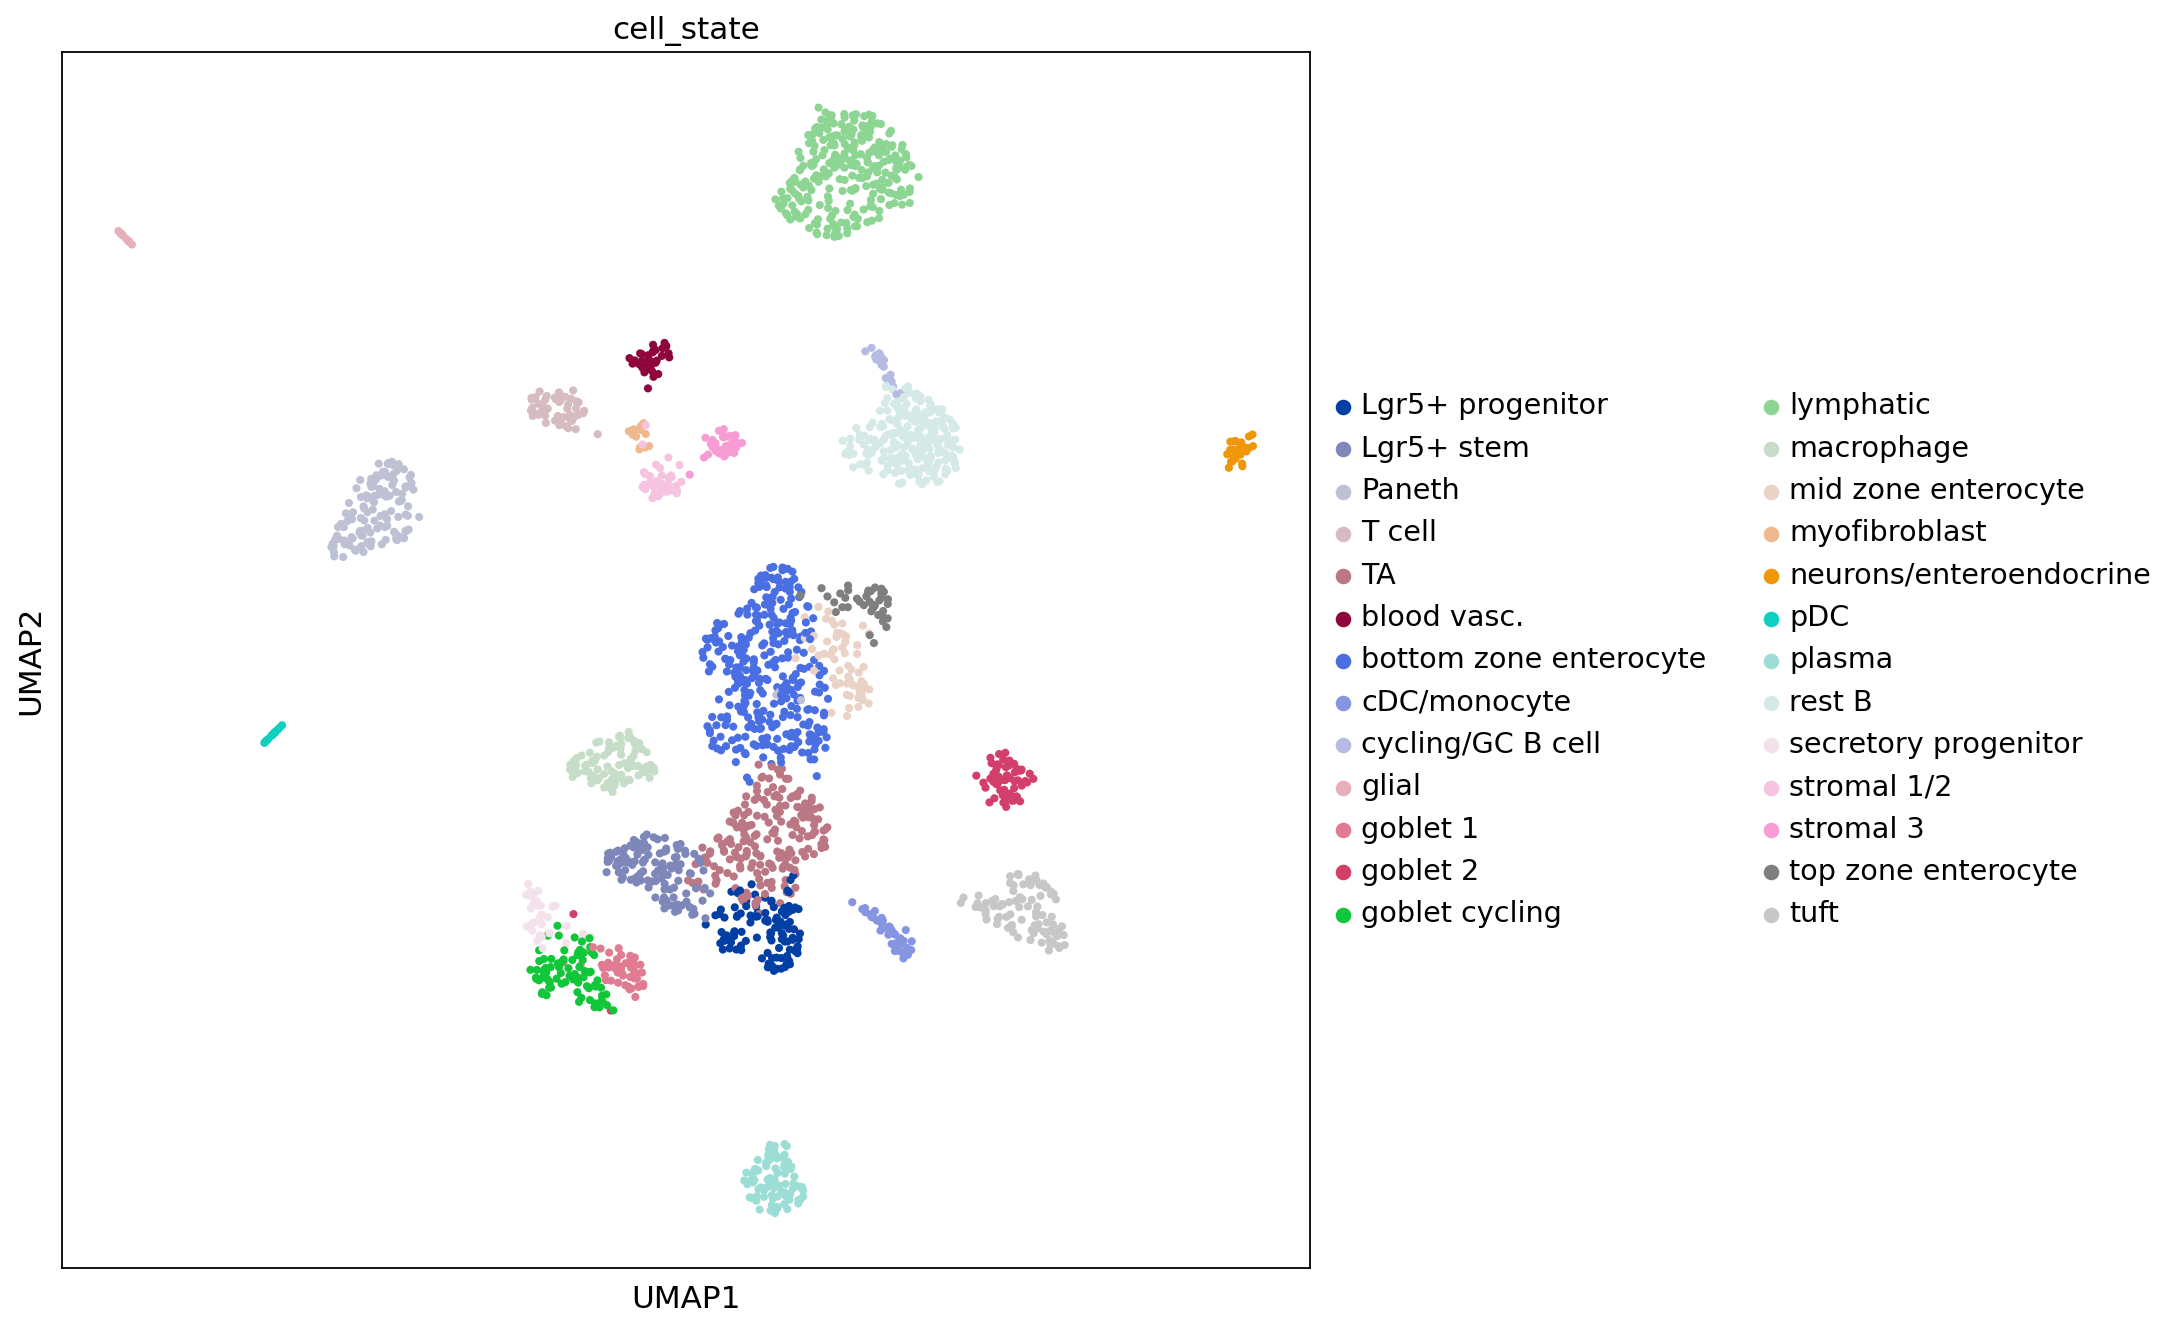

In [61]:
from matplotlib.pyplot import rc_context
with rc_context({'figure.figsize': (10, 10)}):
    sc.pl.umap(adata_dbRM, color='coarse_cluster_dbRM')
    sc.pl.umap(adata_dbRM, color='cell_state')

In [63]:
#save adata
adata_dbRM.write("SI_adata_paper.h5ad")

In [64]:
#visualize expression of selected receptor ligand genes

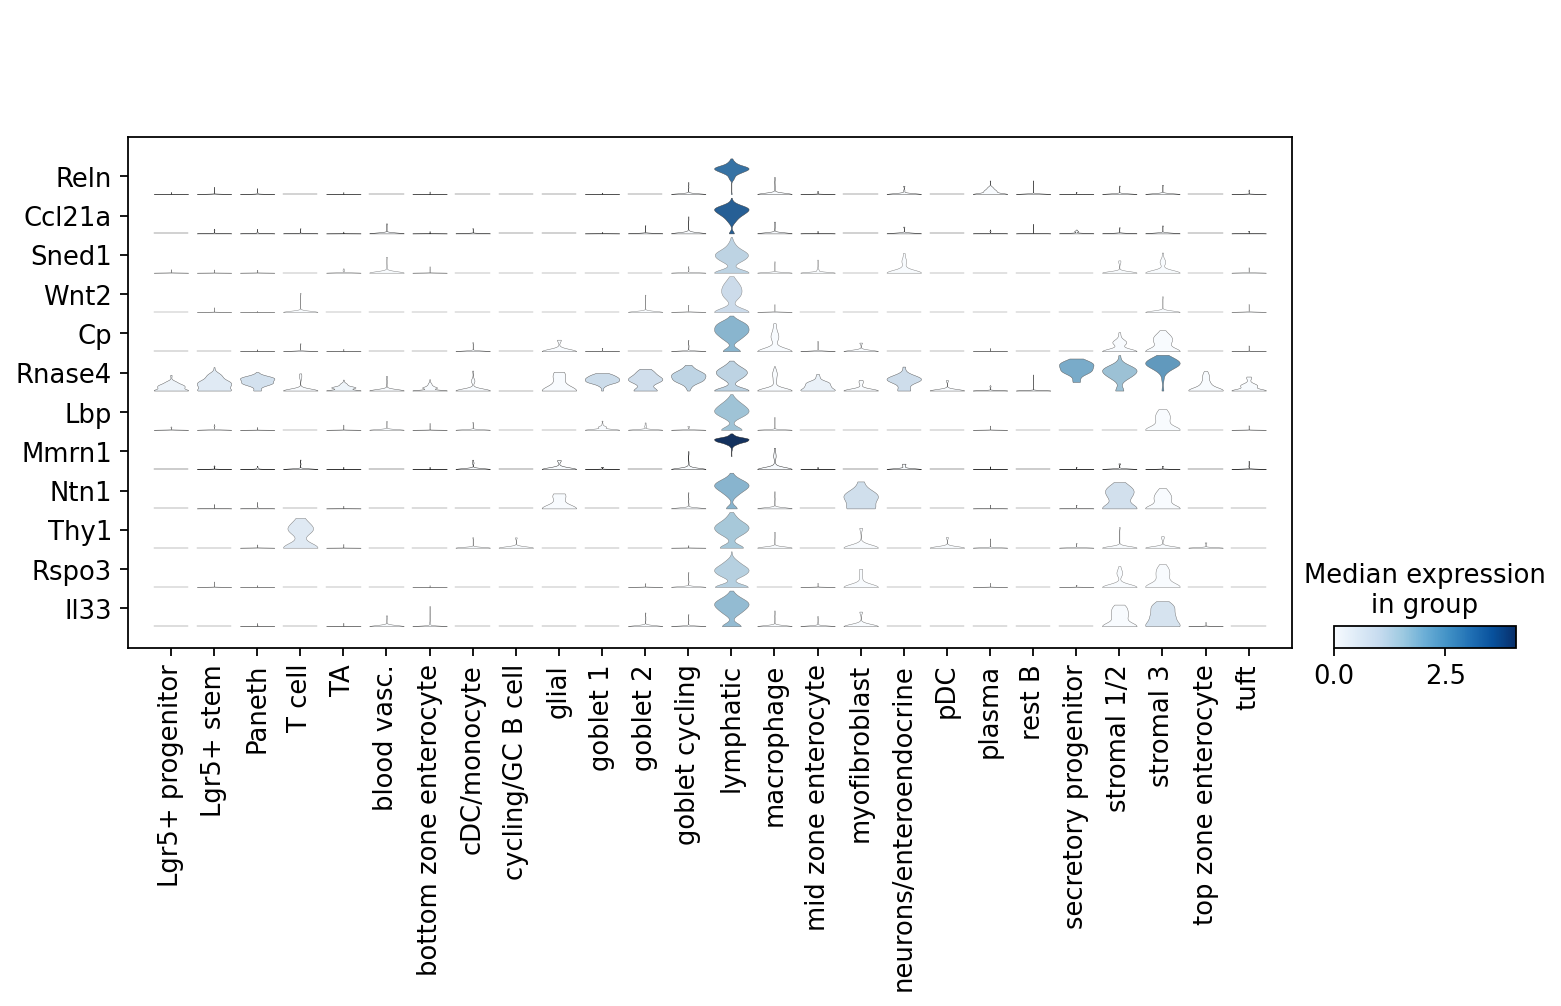

In [65]:
sc.pl.stacked_violin(adata_dbRM, var_names=['Reln','Ccl21a','Sned1','Wnt2','Cp','Rnase4','Lbp','Mmrn1','Ntn1','Thy1','Rspo3','Il33'], groupby='cell_state',swap_axes=True,save="SI_ligand.pdf")

In [66]:
receptor_genes={'Reln':["Itgb1","Vldlr","Lrp8"],
               'Ccl21a':["Ccr7"],
               'Wnt2':["Fzd1","Fzd2","Fzd3","Fzd4","Fzd5","Fzd6","Fzd7","Fzd8","Fzd9","Fzd10","Lrp5","Lrp6"],
               "Ntn1":['Unc5a','Unc5b','Neo1'],
               'Rspo3':['Lgr4','Lgr5'],
               'Il33':['Il1rl1']}

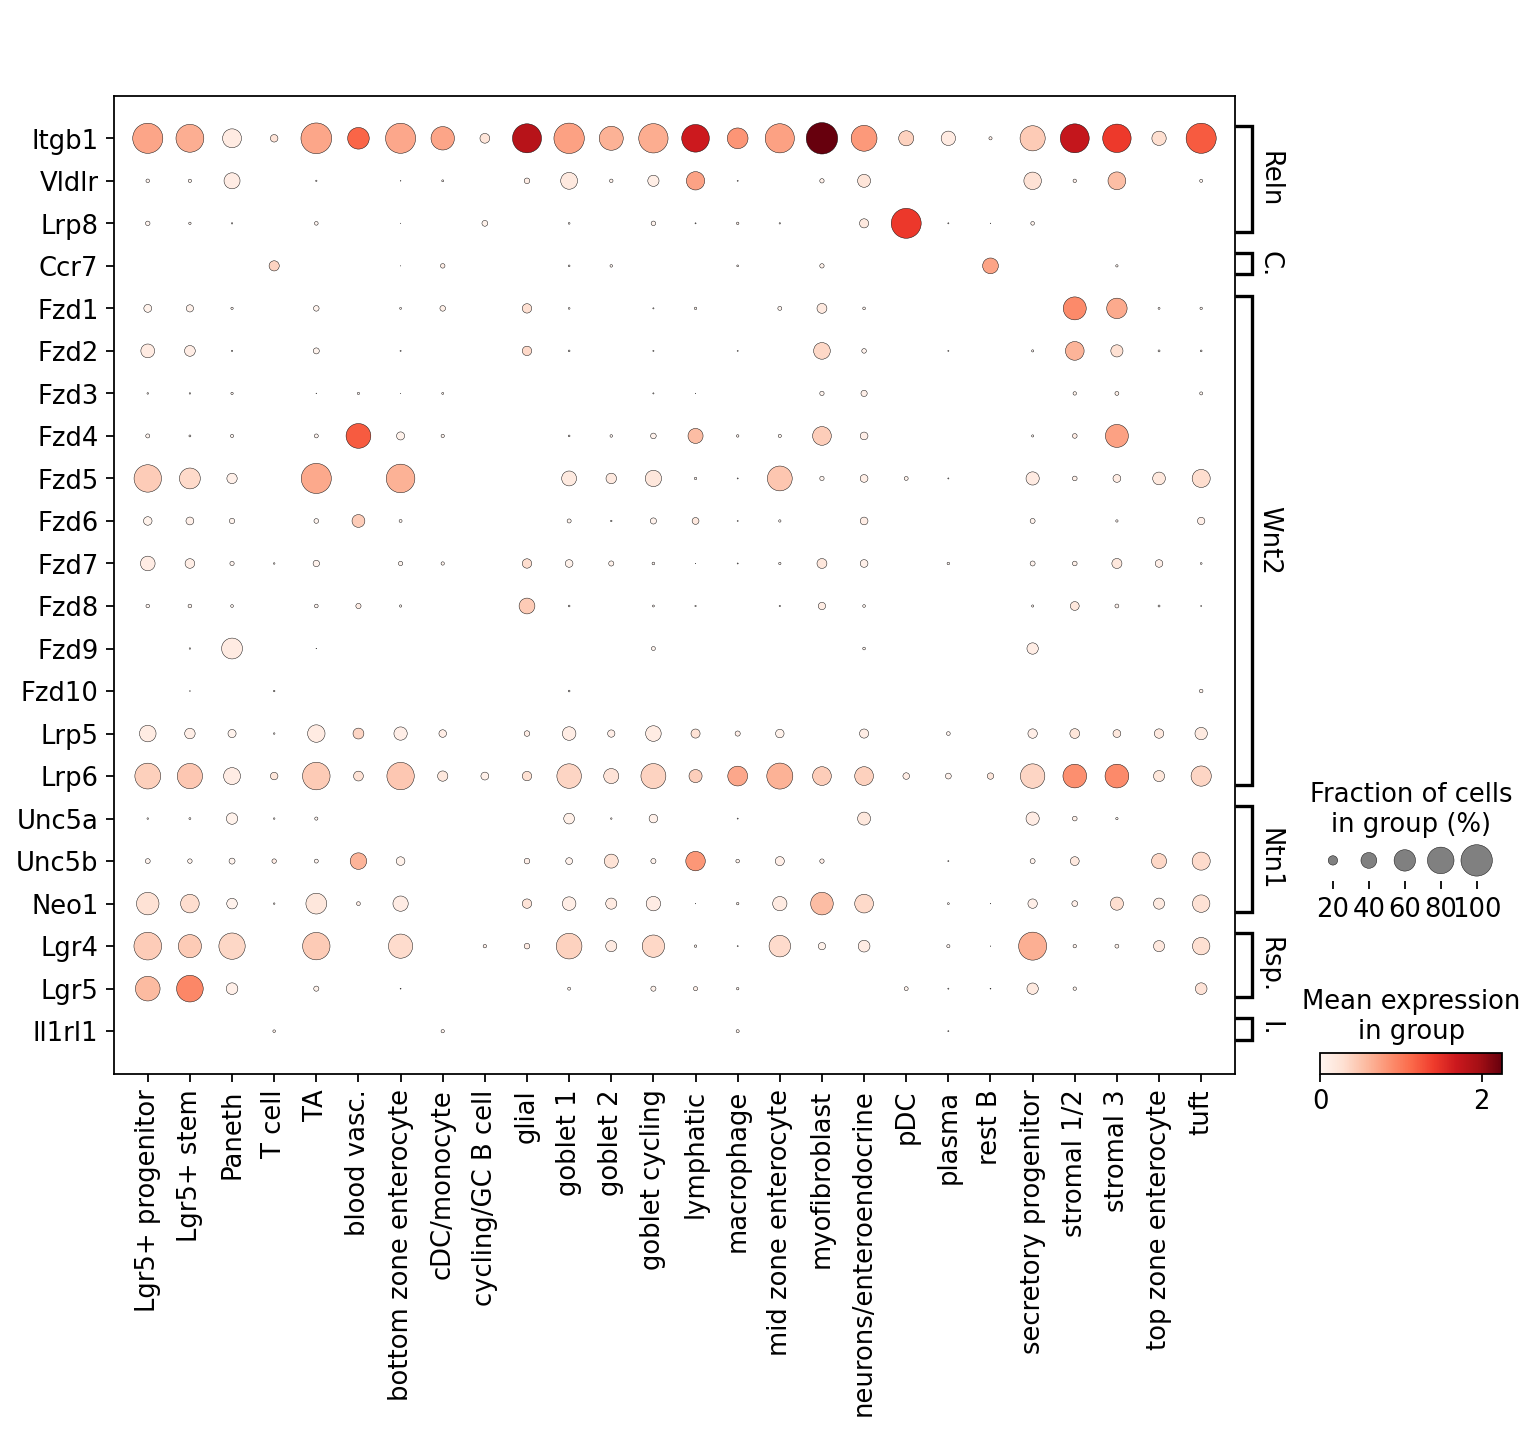

In [67]:
sc.pl.dotplot(adata_dbRM, var_names=receptor_genes, var_group_rotation=180,
                     groupby='cell_state',swap_axes=True,save="SI_receptor_all.pdf")

In [75]:
epi_cell_states=['Paneth','Lgr5+ stem','Lgr5+ progenitor','TA',
                 'bottom zone enterocyte','mid zone enterocyte','top zone enterocyte',
                 'secretory progenitor','goblet cycling','goblet 1','goblet 2',
                 'tuft','neurons/enteroendocrine']

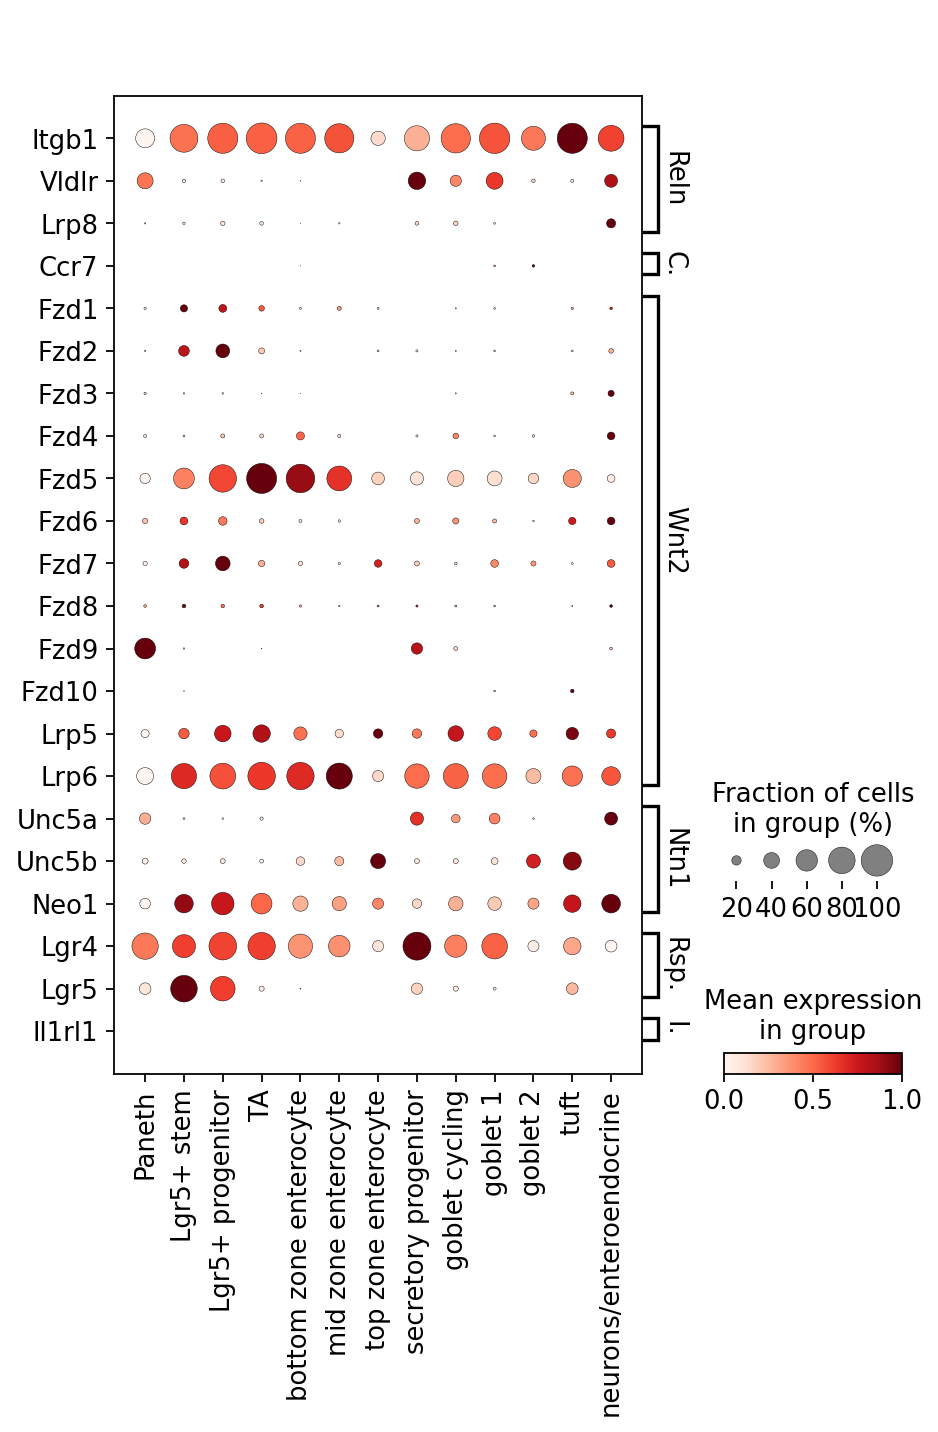

In [76]:
sc.pl.dotplot(adata_dbRM[adata_dbRM.obs['cell_state'].isin(epi_cell_states),:], var_names=receptor_genes, var_group_rotation=180,categories_order=epi_cell_states,
                     groupby='cell_state',swap_axes=True,standard_scale="var",save="SI_receptor_all_std.pdf")

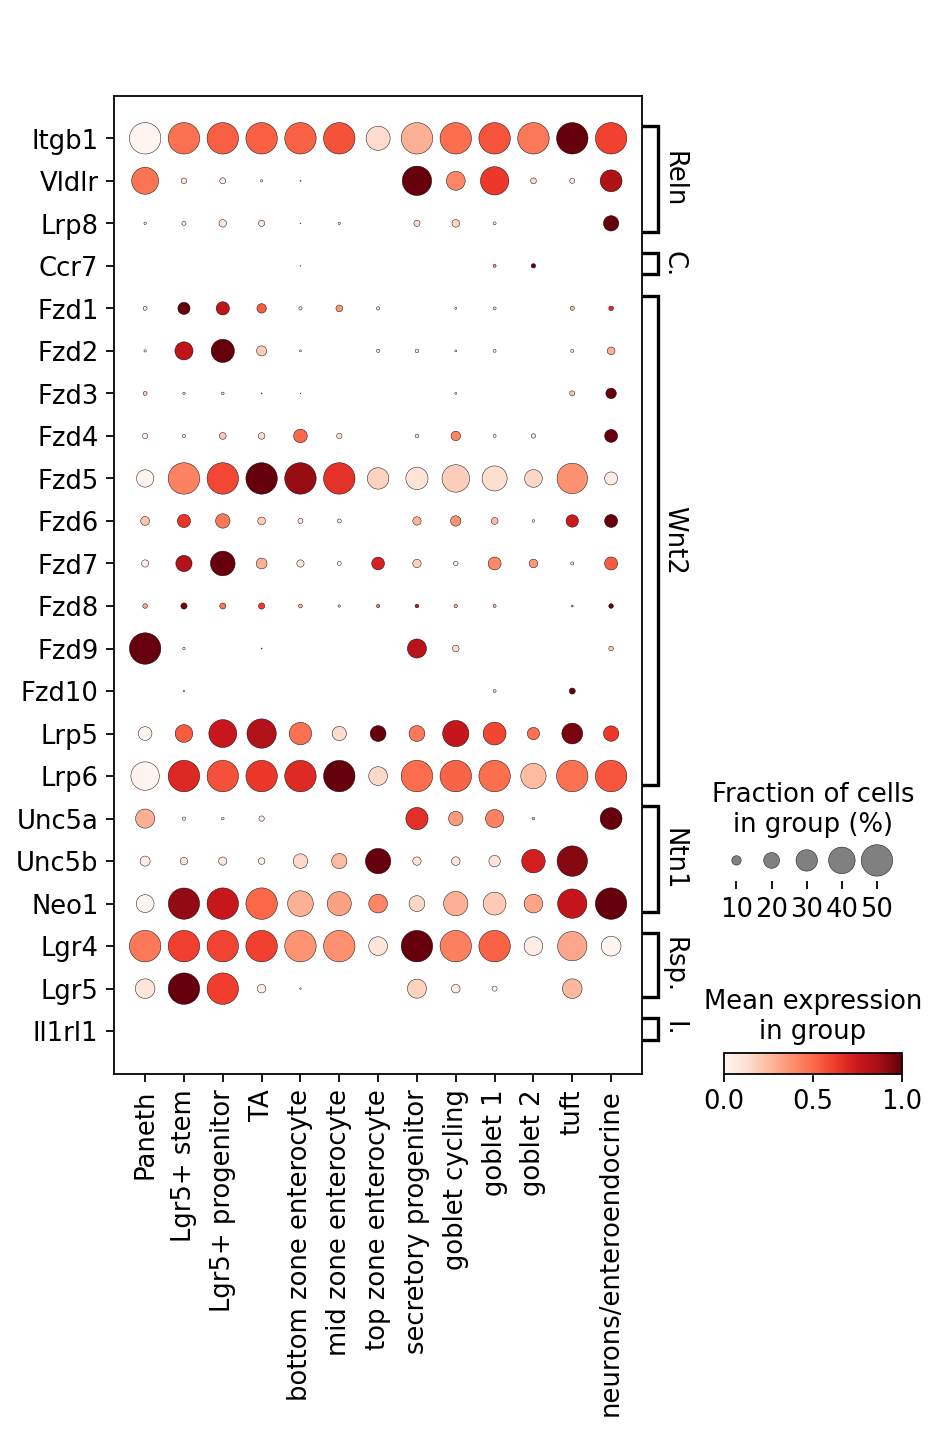

In [77]:
sc.pl.dotplot(adata_dbRM[adata_dbRM.obs['cell_state'].isin(epi_cell_states),:], var_names=receptor_genes, var_group_rotation=180,categories_order=epi_cell_states,
                     groupby='cell_state',swap_axes=True,standard_scale="var",save="SI_receptor_all_std0.5.pdf",dot_max=0.5)

In [78]:
#analyze cluster stability

In [79]:
from sklearn.metrics import adjusted_rand_score



In [80]:
# Compute clusters for various values of k: around k = 30
k_vals = np.arange(21, 42, 3)
cluster_label_list = []
Q_list = []
for k in k_vals:
    cluster_label, graph, Q = phenograph.cluster(adata_ent.obsm['X_pca'],k=k,clustering_algo='leiden',seed=0)
    cluster_label_list.append(cluster_label)
    Q_list.append(Q)

Finding 21 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 1.2305891513824463 seconds
Jaccard graph constructed in 4.004380226135254 seconds
Running Leiden optimization
Leiden completed in 0.006274700164794922 seconds
Sorting communities by size, please wait ...
PhenoGraph completed in 9.236094236373901 seconds
Finding 24 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 0.12292790412902832 seconds
Jaccard graph constructed in 3.9319777488708496 seconds
Running Leiden optimization
Leiden completed in 0.04388308525085449 seconds
Sorting communities by size, please wait ...
PhenoGraph completed in 8.13152265548706 seconds
Finding 27 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 0.13263273239135742 seconds
Jaccard graph constructed in 3.8976211547851562 seconds
Running Leiden optimization
Leiden completed in 0.012176036834716797 seconds
Sorting communities by size, please wait ...
P

/home/chut/miniconda3/envs/cellrank_R/lib/python3.7/site-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  # Remove the CWD from sys.path while we load stuff.


0.7736966649178533

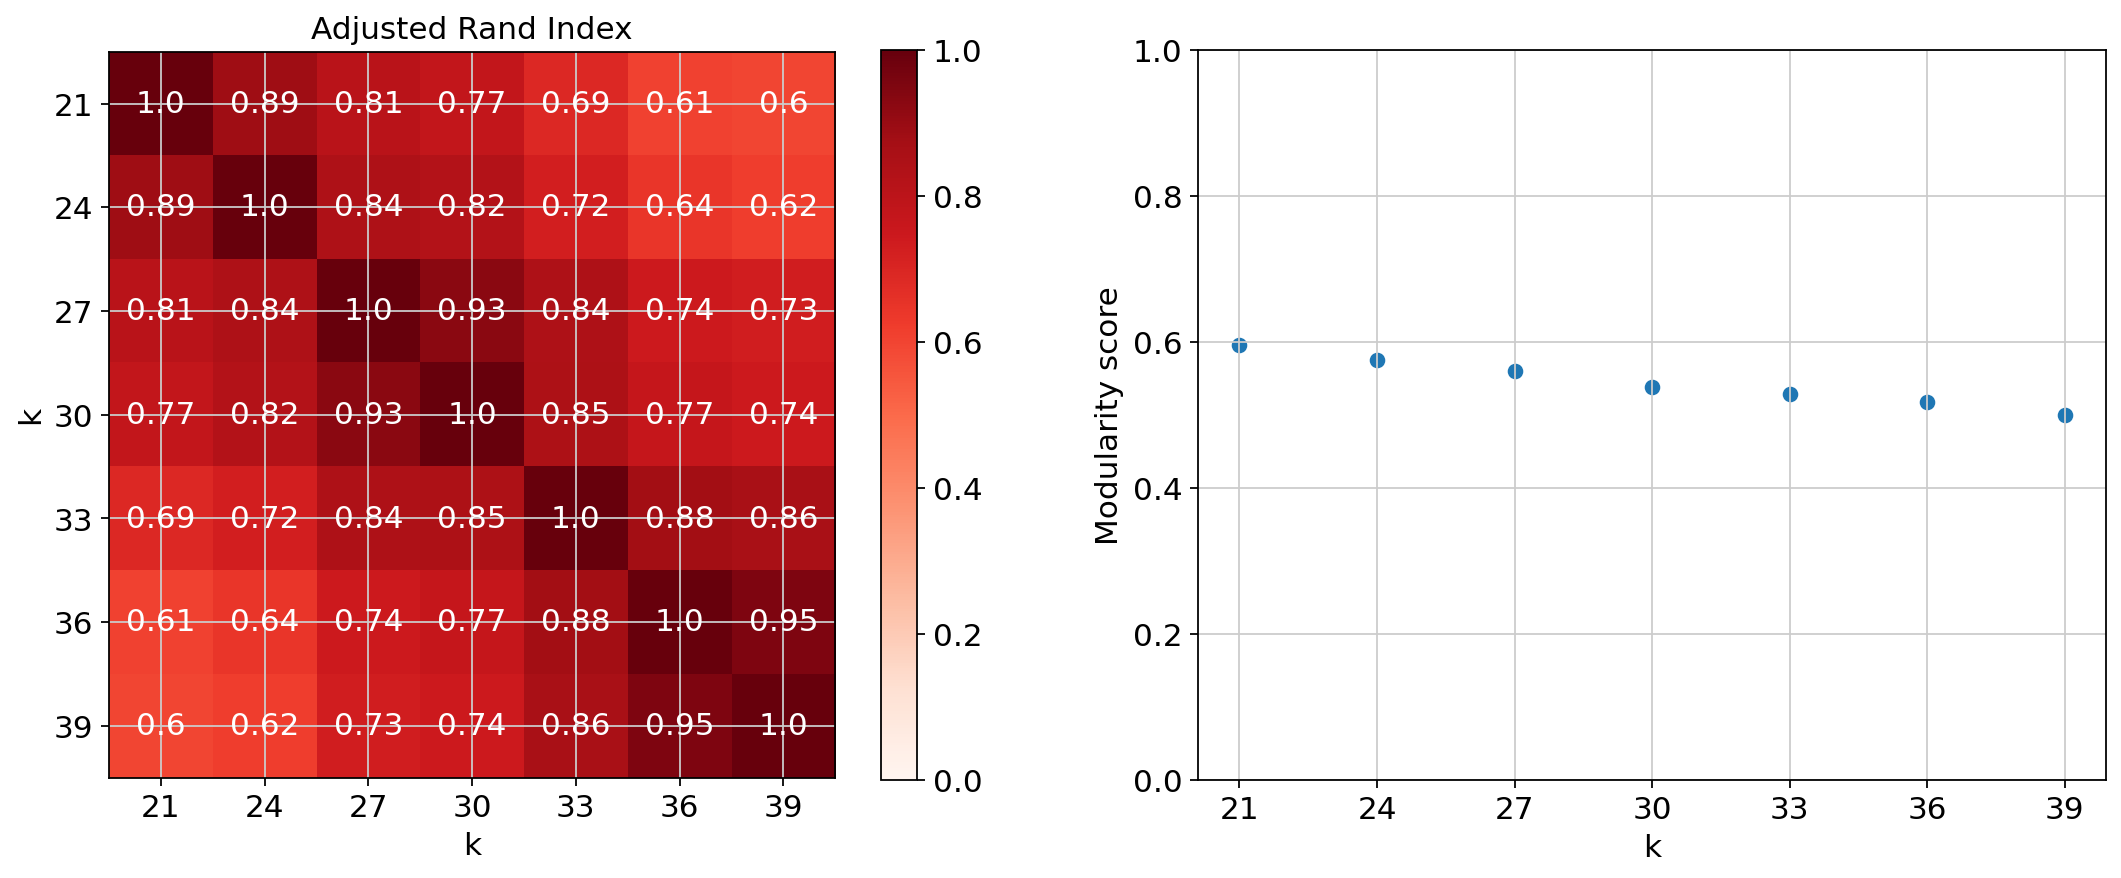

In [81]:
rand_index_mat = np.zeros(shape = (len(k_vals), len(k_vals)))
for ct0 in range(len(k_vals)):
    for ct1 in range(len(k_vals)):
        rand_index_mat[ct0, ct1] = adjusted_rand_score(cluster_label_list[ct0], cluster_label_list[ct1])
fig = plt.figure(figsize = (8*2, 6*1))
ax = fig.add_subplot(1, 2, 1)
im1 = ax.imshow(rand_index_mat, cmap = 'Reds', vmin = 0, vmax = 1)
for (j,i),label in np.ndenumerate(rand_index_mat):
    ax.text(i,j,round(label,2),ha='center',va='center',color="white")
fig.colorbar(im1)
ax.set_xticks(range(len(k_vals)))
ax.set_xticklabels(k_vals)
ax.set_yticks(range(len(k_vals)));
ax.set_yticklabels(k_vals);
ax.set_xlabel('k')
ax.set_ylabel('k')
ax.set_title('Adjusted Rand Index')

ax = fig.add_subplot(1, 2, 2)
ax.scatter(k_vals, Q_list)
ax.grid('on')
ax.set_ylim([0, 1])
ax.set_xticks(k_vals);
ax.set_xlabel('k')
ax.set_ylabel('Modularity score')
np.fill_diagonal(rand_index_mat, np.nan)
np.nanmedian(rand_index_mat.flatten())

Finding 21 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 0.11879920959472656 seconds
Jaccard graph constructed in 3.979975938796997 seconds
Running Leiden optimization
Leiden completed in 0.01668262481689453 seconds
Sorting communities by size, please wait ...
PhenoGraph completed in 8.208869457244873 seconds
Finding 24 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 0.12241339683532715 seconds
Jaccard graph constructed in 4.016679286956787 seconds
Running Leiden optimization
Leiden completed in 0.01342320442199707 seconds
Sorting communities by size, please wait ...
PhenoGraph completed in 10.02245020866394 seconds
Finding 27 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 0.12154388427734375 seconds
Jaccard graph constructed in 4.0120320320129395 seconds
Running Leiden optimization
Leiden completed in 0.010483026504516602 seconds
Sorting communities by size, please wait ...
P

/home/chut/miniconda3/envs/cellrank_R/lib/python3.7/site-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.


0.8541311019175247

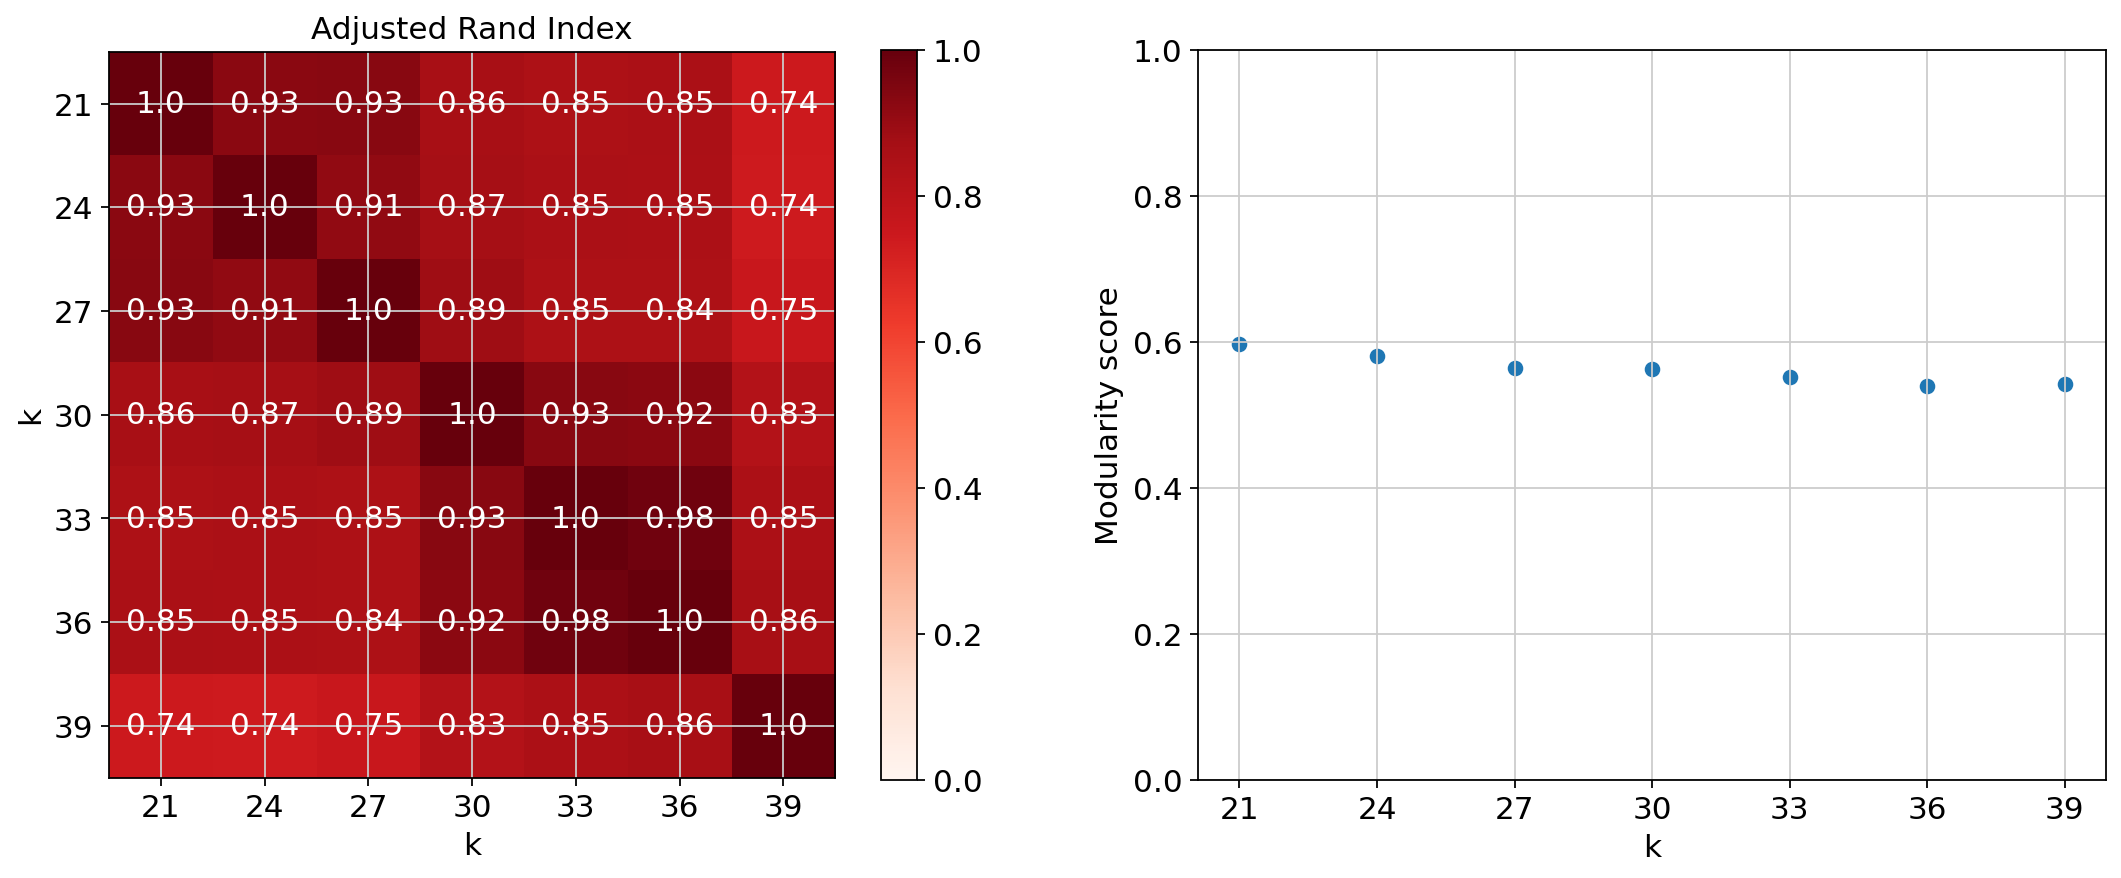

In [82]:
# Compute clusters for various values of k: around k = 30
k_vals = np.arange(21, 42, 3)
cluster_label_list = []
Q_list = []
for k in k_vals:
    cluster_label, graph, Q = phenograph.cluster(adata_stem.obsm['X_pca'],k=k,clustering_algo='leiden',seed=0)
    cluster_label_list.append(cluster_label)
    Q_list.append(Q)
rand_index_mat = np.zeros(shape = (len(k_vals), len(k_vals)))
for ct0 in range(len(k_vals)):
    for ct1 in range(len(k_vals)):
        rand_index_mat[ct0, ct1] = adjusted_rand_score(cluster_label_list[ct0], cluster_label_list[ct1])
fig = plt.figure(figsize = (8*2, 6*1))
ax = fig.add_subplot(1, 2, 1)
im1 = ax.imshow(rand_index_mat, cmap = 'Reds', vmin = 0, vmax = 1)
for (j,i),label in np.ndenumerate(rand_index_mat):
    ax.text(i,j,round(label,2),ha='center',va='center',color="white")
fig.colorbar(im1)
ax.set_xticks(range(len(k_vals)))
ax.set_xticklabels(k_vals)
ax.set_yticks(range(len(k_vals)));
ax.set_yticklabels(k_vals);
ax.set_xlabel('k')
ax.set_ylabel('k')
ax.set_title('Adjusted Rand Index')

ax = fig.add_subplot(1, 2, 2)
ax.scatter(k_vals, Q_list)
ax.grid('on')
ax.set_ylim([0, 1])
ax.set_xticks(k_vals);
ax.set_xlabel('k')
ax.set_ylabel('Modularity score')
np.fill_diagonal(rand_index_mat, np.nan)
np.nanmedian(rand_index_mat.flatten())

Finding 21 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 0.34766221046447754 seconds
Jaccard graph constructed in 5.923739433288574 seconds
Running Leiden optimization
Leiden completed in 0.2212522029876709 seconds
Sorting communities by size, please wait ...
PhenoGraph completed in 14.20947813987732 seconds
Finding 24 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 0.12072396278381348 seconds
Jaccard graph constructed in 5.680003881454468 seconds
Running Leiden optimization
Leiden completed in 0.007021188735961914 seconds
Sorting communities by size, please wait ...
PhenoGraph completed in 9.995410442352295 seconds
Finding 27 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 0.11770772933959961 seconds
Jaccard graph constructed in 5.593757390975952 seconds
Running Leiden optimization
Leiden completed in 0.007659435272216797 seconds
Sorting communities by size, please wait ...
Ph

/home/chut/miniconda3/envs/cellrank_R/lib/python3.7/site-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.


0.8653688866733706

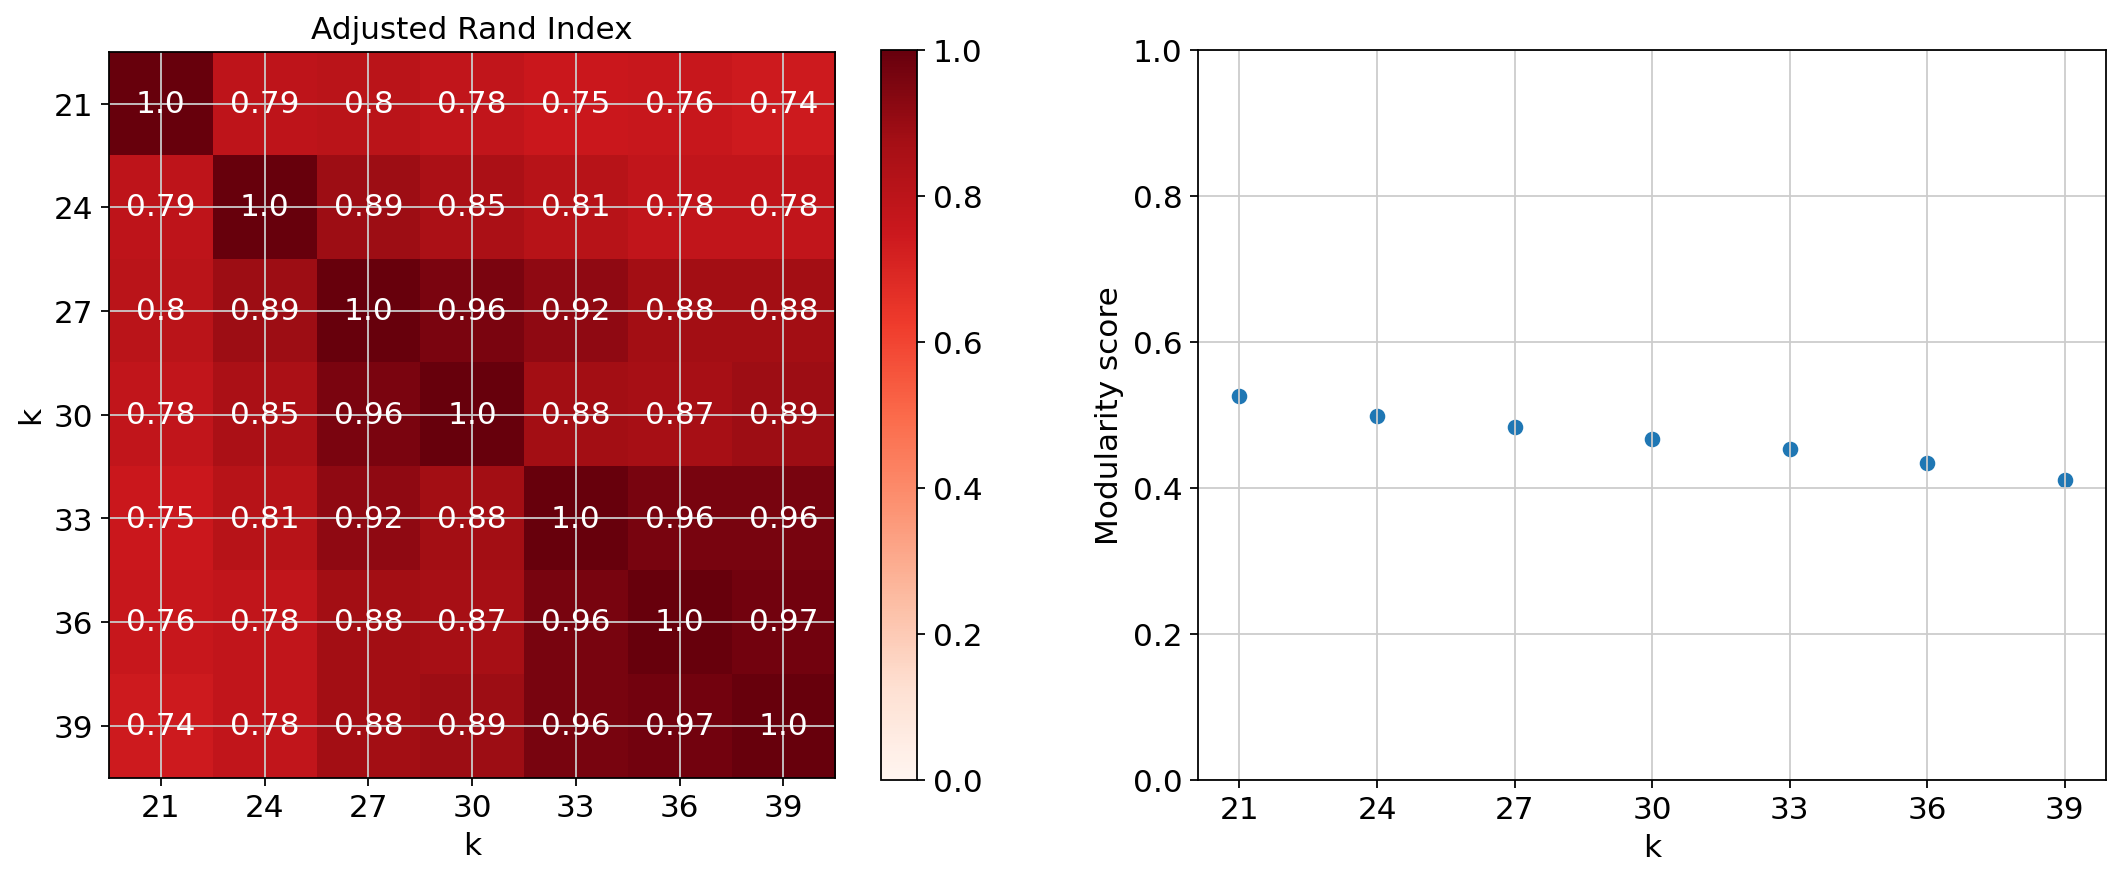

In [83]:
# Compute clusters for various values of k: around k = 30
k_vals = np.arange(21, 42, 3)
cluster_label_list = []
Q_list = []
for k in k_vals:
    cluster_label, graph, Q = phenograph.cluster(adata_gob.obsm['X_pca'],k=k,clustering_algo='leiden',seed=0)
    cluster_label_list.append(cluster_label)
    Q_list.append(Q)
rand_index_mat = np.zeros(shape = (len(k_vals), len(k_vals)))
for ct0 in range(len(k_vals)):
    for ct1 in range(len(k_vals)):
        rand_index_mat[ct0, ct1] = adjusted_rand_score(cluster_label_list[ct0], cluster_label_list[ct1])
fig = plt.figure(figsize = (8*2, 6*1))
ax = fig.add_subplot(1, 2, 1)
im1 = ax.imshow(rand_index_mat, cmap = 'Reds', vmin = 0, vmax = 1)
for (j,i),label in np.ndenumerate(rand_index_mat):
    ax.text(i,j,round(label,2),ha='center',va='center',color="white")
fig.colorbar(im1)
ax.set_xticks(range(len(k_vals)))
ax.set_xticklabels(k_vals)
ax.set_yticks(range(len(k_vals)));
ax.set_yticklabels(k_vals);
ax.set_xlabel('k')
ax.set_ylabel('k')
ax.set_title('Adjusted Rand Index')

ax = fig.add_subplot(1, 2, 2)
ax.scatter(k_vals, Q_list)
ax.grid('on')
ax.set_ylim([0, 1])
ax.set_xticks(k_vals);
ax.set_xlabel('k')
ax.set_ylabel('Modularity score')
np.fill_diagonal(rand_index_mat, np.nan)
np.nanmedian(rand_index_mat.flatten())

Finding 21 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 0.11246085166931152 seconds
Jaccard graph constructed in 3.7274222373962402 seconds
Running Leiden optimization
Leiden completed in 0.0024688243865966797 seconds
Sorting communities by size, please wait ...
PhenoGraph completed in 7.965261936187744 seconds
Finding 24 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 0.11217117309570312 seconds
Jaccard graph constructed in 3.8133609294891357 seconds
Running Leiden optimization
Leiden completed in 0.0026209354400634766 seconds
Sorting communities by size, please wait ...
PhenoGraph completed in 8.076147317886353 seconds
Finding 27 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 0.11340665817260742 seconds
Jaccard graph constructed in 3.734992742538452 seconds
Running Leiden optimization
Leiden completed in 0.0017926692962646484 seconds
Sorting communities by size, please wait

/home/chut/miniconda3/envs/cellrank_R/lib/python3.7/site-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.


1.0

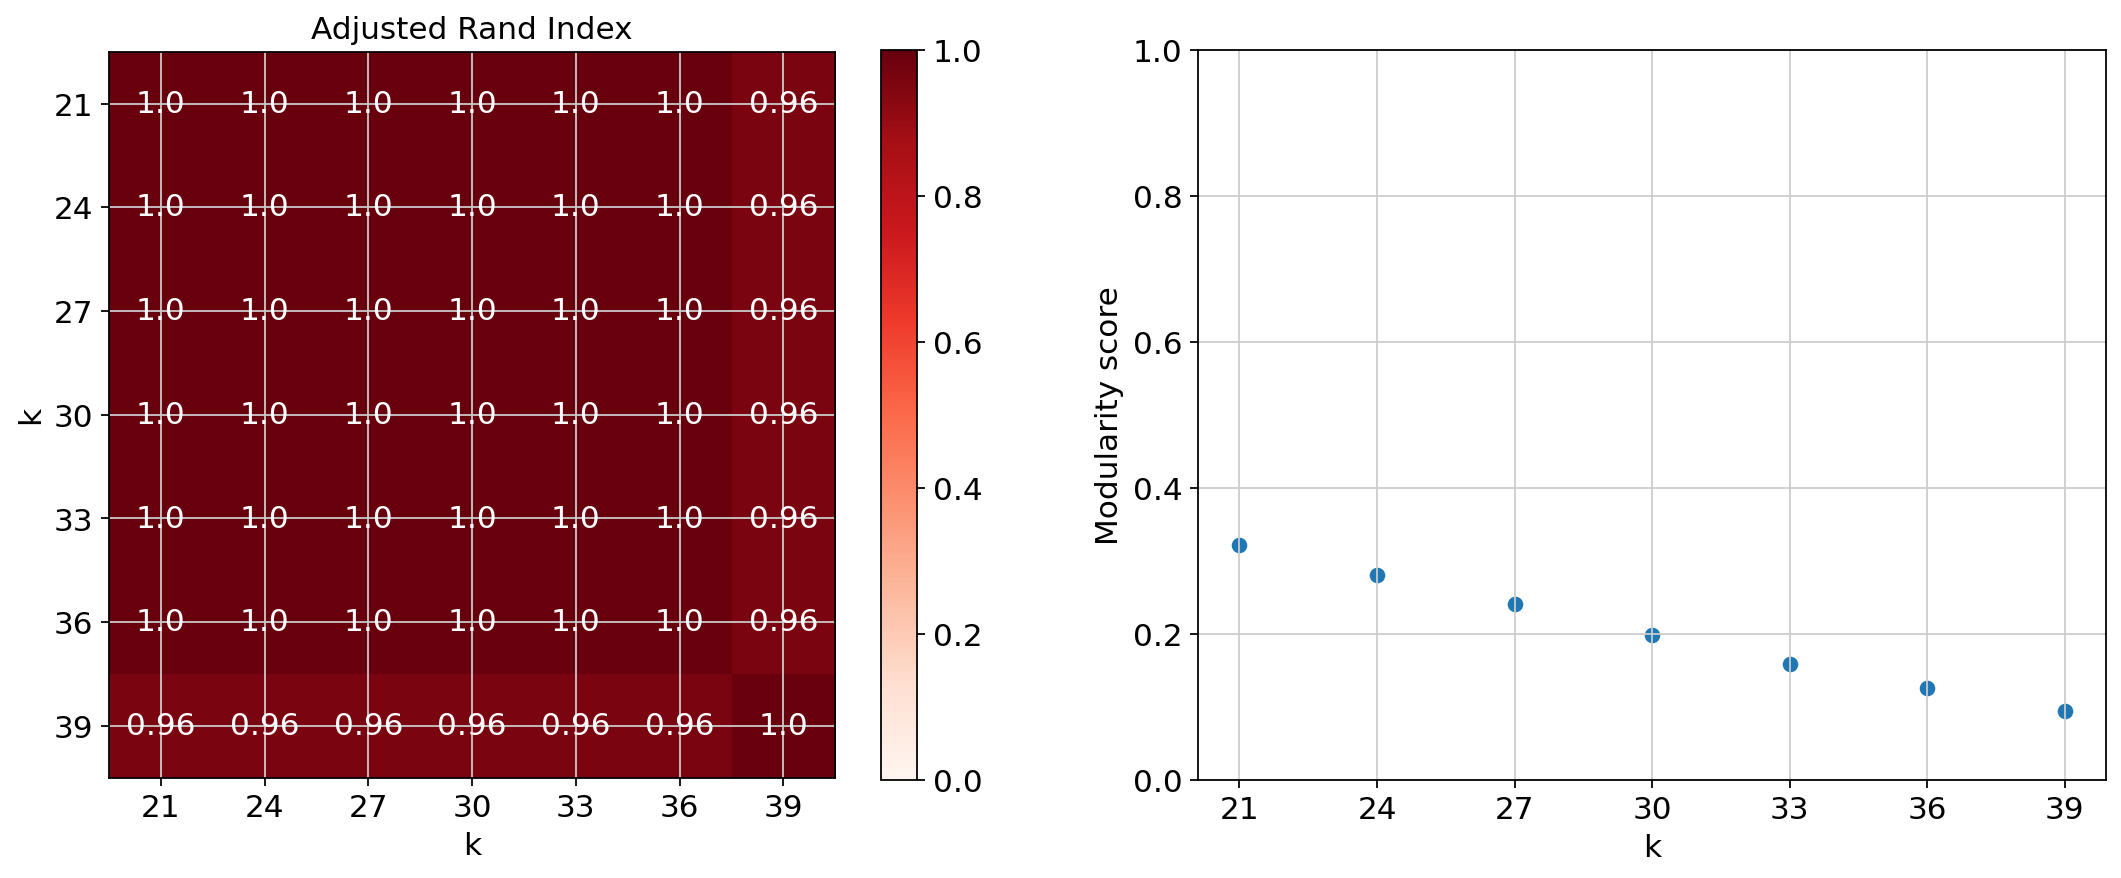

In [84]:
# Compute clusters for various values of k: around k = 30
k_vals = np.arange(21, 42, 3)
cluster_label_list = []
Q_list = []
for k in k_vals:
    cluster_label, graph, Q = phenograph.cluster(adata_str.obsm['X_pca'],k=k,clustering_algo='leiden',seed=0)
    cluster_label_list.append(cluster_label)
    Q_list.append(Q)
rand_index_mat = np.zeros(shape = (len(k_vals), len(k_vals)))
for ct0 in range(len(k_vals)):
    for ct1 in range(len(k_vals)):
        rand_index_mat[ct0, ct1] = adjusted_rand_score(cluster_label_list[ct0], cluster_label_list[ct1])
fig = plt.figure(figsize = (8*2, 6*1))
ax = fig.add_subplot(1, 2, 1)
im1 = ax.imshow(rand_index_mat, cmap = 'Reds', vmin = 0, vmax = 1)
for (j,i),label in np.ndenumerate(rand_index_mat):
    ax.text(i,j,round(label,2),ha='center',va='center',color="white")
fig.colorbar(im1)
ax.set_xticks(range(len(k_vals)))
ax.set_xticklabels(k_vals)
ax.set_yticks(range(len(k_vals)));
ax.set_yticklabels(k_vals);
ax.set_xlabel('k')
ax.set_ylabel('k')
ax.set_title('Adjusted Rand Index')

ax = fig.add_subplot(1, 2, 2)
ax.scatter(k_vals, Q_list)
ax.grid('on')
ax.set_ylim([0, 1])
ax.set_xticks(k_vals);
ax.set_xlabel('k')
ax.set_ylabel('Modularity score')
np.fill_diagonal(rand_index_mat, np.nan)
np.nanmedian(rand_index_mat.flatten())